# Purpose

2021-08-02: Now that I'm processing millions of comments and posts, I need to re-write the functions to try to do some work in parallel and reduce the amount of data loaded in RAM.

- `Dask` seems like a great option to load data and only compute some of it as needed.
- `cuDF` could be a way to speed up some computation using GPUs
- `Dask-delayed` could be a way to create a task DAG lazily before computing all the aggregates.


---

In notebook 09 I combined embeddings from posts & subreddits (`djb_09.00-combine_post_and_comments_and_visualize_for_presentation.ipynb`).

In this notebook I'll be testing functions that include mlflow so that it's easier to try a lot of different weights to find better respresentations.

Take embeddings created by other models & combine them:
```
new post embeddings = post + comments + subreddit description

new subreddit embeddings = new posts (weighted by post length or upvotes?)
```

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import os
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import dask
from dask import dataframe as dd
from tqdm.auto import tqdm

import mlflow
import hydra

import subclu
from subclu.models.aggregate_embeddings import (
    AggregateEmbeddings, AggregateEmbeddingsConfig,
    load_config_agg_jupyter, get_dask_df_shape,
)

from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger, save_pd_df_to_parquet_in_chunks
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([dask, hydra, mlflow, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
hydra		v: 1.1.0
mlflow		v: 1.16.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active


## Get runs that we can use for embeddings aggregation jobs

In [6]:
%%time

df_mlf_runs =  mlf.search_all_runs(experiment_ids=[9, '10', 11, 12])
df_mlf_runs.shape

CPU times: user 269 ms, sys: 4.55 ms, total: 273 ms
Wall time: 272 ms


(105, 79)

In [7]:
mask_finished = df_mlf_runs['status'] == 'FINISHED'
mask_output_over_1M_rows = (
    (df_mlf_runs['metrics.df_vect_posts_rows'] >= 1e6) |
    (df_mlf_runs['metrics.df_vect_comments'] >= 1e6)
)
# df_mlf_runs[mask_finished].shape

df_mlf_use_for_agg = df_mlf_runs[mask_output_over_1M_rows]
df_mlf_use_for_agg.shape

(3, 79)

In [8]:
cols_with_multiple_vals = df_mlf_use_for_agg.columns[df_mlf_use_for_agg.nunique(dropna=False) > 1]
# len(cols_with_multiple_vals)

style_df_numeric(
    df_mlf_use_for_agg
    [cols_with_multiple_vals]
    .drop(['artifact_uri', 'end_time',
           # 'start_time',
           ], 
          axis=1)
    .dropna(axis='columns', how='all')
    .iloc[:, :30]
    ,
    rename_cols_for_display=True,
)

,run id,experiment id,status,start time,metrics.df vect subreddits description cols,metrics.vectorizing time minutes posts,metrics.vectorizing time minutes comments,metrics.total comment files processed,metrics.vectorizing time minutes subreddit meta,metrics.df vect posts rows,metrics.df vect comments,metrics.vectorizing time minutes full function,metrics.df vect subreddits description rows,metrics.df vect posts cols,params.tf limit first n chars,params.batch comment files,params.posts path,params.tokenize lowercase,params.tf batch inference rows,params.subreddits path,tags.mlflow.source.git.commit,tags.mlflow.runName
82,a948e9fd651545f997430cddc6b529eb,10,FINISHED,2021-07-29 23:02:33.997000+00:00,514.00,14.74,145.73,37.00,0.08,"1,649,929.00","19,168,154.00",176.77,"3,767.00",515.00,1000,True,posts/top/2021-07-16,True,2000,subreddits/top/2021-07-16,63f5f420fb6b48d8243749cba183071757dac531,new_batch_fxn-2021-07-29_230233
84,e66c5db26bd64f6da09c012eea700d0a,10,FINISHED,2021-07-29 18:59:48.715000+00:00,-,-,117.47,37.00,-,-,"19,200,854.00",133.16,-,-,850,True,None,False,6100,None,64f49e85a8ef56a6795edf9da9a6f5964cb6830b,new_batch_fxn_2021-07-29_185948
93,614a38e6690c4f3ba08725b1585b2ee9,9,KILLED,2021-07-29 11:49:53.924000+00:00,514.00,10.01,-,-,0.07,"1,649,929.00",-,-,"3,767.00",515.00,1000,None,posts/top/2021-07-16,False,2100,subreddits/top/2021-07-16,64f49e85a8ef56a6795edf9da9a6f5964cb6830b,test_new_fxn2021-07-29_114953


# Load configs for aggregation jobs

Note that by default `hydra` is a cli tool. If we want to call use it in jupyter, we need to manually initialize configs & compose the configuration. See my custom function `load_config_agg_jupyter`. Also see:
- [Notebook with `Hydra` examples in a notebook](https://github.com/facebookresearch/hydra/blob/master/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb).
- [Hydra docs, Hydra in Jupyter](https://hydra.cc/docs/next/advanced/jupyter_notebooks/).


In [9]:
mlflow_experiment_test = 'v0.3.2_use_multi_aggregates_test'
mlflow_experiment_full = 'v0.3.2_use_multi_aggregates'

config_test_sample_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=5',     # 51 total
               'n_sample_comments_files=10',  # 34 total
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)
config_test_full_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_test}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

config_full_lc_false = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_full}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_false',
              ]
)

config_full_lc_true = AggregateEmbeddingsConfig(
    config_path="../config",
    config_name='aggregate_embeddings',
    overrides=[f"mlflow_experiment={mlflow_experiment_full}",
               'n_sample_posts_files=null', 
               'n_sample_comments_files=null',
               'data_embeddings_to_aggregate=top_subs-2021_07_16-use_multi_lower_case_true',
              ]
)
# pprint(config_test_sample_lc_false.config_dict, indent=2)

In [10]:
df_configs = pd.DataFrame(
    [config_test_sample_lc_false.config_flat,
     config_test_full_lc_false.config_flat,
     config_full_lc_false.config_flat,
     config_full_lc_true.config_flat,
    ]
)
cols_with_diffs_config = df_configs.columns[df_configs.nunique(dropna=False) > 1]
df_configs[cols_with_diffs_config]

,comments_uuid,posts_uuid,subreddit_desc_uuid,mlflow_experiment,n_sample_posts_files,n_sample_comments_files
0,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates_test,5.0,10.0
1,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates_test,NaN,NaN
2,e66c5db26bd64f6da09c012eea700d0a,614a38e6690c4f3ba08725b1585b2ee9,614a38e6690c4f3ba08725b1585b2ee9,v0.3.2_use_multi_aggregates,NaN,NaN
3,a948e9fd651545f997430cddc6b529eb,a948e9fd651545f997430cddc6b529eb,a948e9fd651545f997430cddc6b529eb,v0.3.2_use_multi_aggregates,NaN,NaN


In [11]:
pprint(config_test_sample_lc_false.config_flat, indent=2)

{ 'agg_comments_to_post_weight_col': None,
  'agg_post_comment_weight': 20,
  'agg_post_post_weight': 70,
  'agg_post_subreddit_desc_weight': 10,
  'agg_post_to_subreddit_weight_col': None,
  'bucket_name': 'i18n-subreddit-clustering',
  'col_comment_id': 'comment_id',
  'col_post_id': 'post_id',
  'col_subreddit_id': 'subreddit_id',
  'col_text_comment_word_count': 'comment_text_word_count',
  'col_text_post_word_count': 'text_word_count',
  'comments_folder_embeddings': 'df_vect_comments',
  'comments_uuid': 'e66c5db26bd64f6da09c012eea700d0a',
  'dataset_name': 'Top Subreddits (no Geo) + German Subs 2021-07-16, comments: '
                  '2021-07-09',
  'folder_comments_text_and_meta': 'comments/top/2021-07-09',
  'folder_posts_text_and_meta': 'posts/top/2021-07-16',
  'folder_subreddits_text_and_meta': 'subreddits/top/2021-07-16',
  'min_comment_text_len': 10,
  'mlflow_experiment': 'v0.3.2_use_multi_aggregates_test',
  'mlflow_tracking_uri': 'sqlite',
  'n_sample_comments_files'

In [ ]:
BREAK

# Initialize a local dask client
so that we can see the progress/process for dask jobs

In [12]:
%%time

from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=16) # dask sets the default to 8 workers with 64 CPUs present
client = Client(cluster)

CPU times: user 466 ms, sys: 343 ms, total: 809 ms
Wall time: 1.72 s


In [13]:
client.dashboard_link

'http://127.0.0.1:8787/status'

# Run test with a few files (n_sample)
`n_sample_comments_files` and `n_sample_posts_files` allow us to only load a few files at a time (e.g., 2 instead of 50) to test the process end-to-end.

The logic for sampling files and download/`caching` files locally lives in the `mlf` custom function.

Caching can save 9+ minutes if we try to download the files from GCS every time.

In [ ]:
BREAK

In [213]:
# try:
#     del d_dfs2, job_agg2
# except NameError:
#     pass
# gc.collect()

In [14]:
%%time

mlflow.end_run("FAILED")
gc.collect()
try:
    del job_agg2
    # del d_dfs2
except NameError:
    pass
gc.collect()

job_agg2 = AggregateEmbeddings(
    run_name=f"test_new_class_sample-{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    **config_test_sample_lc_false.config_flat
)
job_agg2.run_aggregation()

gc.collect()

05:54:29 | INFO | "== Start run_aggregation() method =="
05:54:29 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
05:54:29 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-08-10_055429-test_new_class_sample-2021-08-10_055429"
05:54:29 | INFO | "  Saving config to local path..."
05:54:29 | INFO | "  Logging config to mlflow..."
05:54:30 | INFO | "-- Start _load_raw_embeddings() method --"
05:54:30 | INFO | "Loading subreddit description embeddings..."
05:54:31 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"


  0%|          | 0/4 [00:00<?, ?it/s]

05:54:31 | INFO | "  Reading 1 files"
05:54:32 | INFO | "       3,767 |  513 <- Raw vectorized subreddit description shape"
05:54:33 | INFO | "Loading POSTS embeddings..."
05:54:33 | INFO | "  Sampling POSTS FILES down to: 5"
05:54:33 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

05:54:33 | INFO | "  Reading 5 files"
05:54:37 | INFO | "     171,870 |  514 <- Raw POSTS shape"
05:54:39 | INFO | "Loading COMMENTS embeddings..."
05:54:39 | INFO | "  Sampling COMMENTS FILES down to: 10"
05:54:39 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

05:54:39 | INFO | "  Reading 10 files"
05:54:39 | INFO | "  Keep only comments for posts with embeddings"
05:54:41 | INFO | "  0:00:10.759361 <- Total raw embeddings load time elapsed"
05:54:41 | INFO | "-- Start _agg_comments_to_post_level() method --"
05:54:41 | INFO | "Getting count of comments per post..."
05:56:10 | INFO | "Filtering which comments need to be averaged..."
05:56:26 | INFO | "       13,161 <- Comments that DON'T need to be averaged"
05:56:26 | INFO | "      740,151 <- Comments that need to be averaged"
05:56:26 | INFO | "No column to weight comments, simple mean for comments at post level"
05:56:40 | INFO | "       49,732 |  514 <- df_v_com_agg SHAPE"
05:56:40 | INFO | "  0:01:59.020487 <- Total comments to post agg loading time elapsed"
05:56:40 | INFO | "-- Start (df_posts_agg_b) _agg_posts_and_comments_to_post_level() method --"
05:56:41 | INFO | "DEFINE agg_posts_w_comments..."
05:56:41 | INFO | "  (Delayed('int-24cc8157-eeb4-46b1-8f3a-ae0d678e2713'), 513) <- df

  0%|          | 0/11 [00:00<?, ?it/s]

06:03:53 | INFO | "** df_post_level_agg_b_post_and_comments **"
06:03:53 | INFO | "Saving locally..."
06:04:28 | INFO | "      21	<- EXISTING Dask partitions"
06:04:58 | INFO | "Logging artifact to mlflow..."
06:05:10 | INFO | "** df_post_level_agg_c_post_comments_sub_desc **"
06:05:10 | INFO | "Saving locally..."
06:06:37 | INFO | "      42	<- EXISTING Dask partitions"
06:08:07 | INFO | "Logging artifact to mlflow..."
06:08:25 | INFO | "** df_sub_level_agg_a_post_only **"
06:08:25 | INFO | "Saving locally..."
06:08:26 | INFO | "       1	<- EXISTING Dask partitions"
06:08:28 | INFO | "Logging artifact to mlflow..."
06:08:29 | INFO | "** df_sub_level_agg_a_post_only_similarity **"
06:08:29 | INFO | "Saving locally..."
06:08:29 | INFO | "Keeping index intact..."
06:08:29 | INFO | "   103.5 MB <- Memory usage"
06:08:29 | INFO | "       3	<- target Dask partitions	   40.0 <- target MB partition size"
06:08:33 | INFO | "Logging artifact to mlflow..."
06:08:35 | INFO | "** df_sub_level_agg_a

CPU times: user 6min 10s, sys: 58.7 s, total: 7min 8s
Wall time: 19min 34s


18730

In [15]:
mlflow.end_run("FAILED")

## Check output dfs

In [16]:
%%time

d_dfs2 = dict()
(
    d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
#     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta'],
    
    # Aggs don't get computed until run_aggergation() method gets called
    d_dfs2['df_subs_agg_a'], d_dfs2['df_subs_agg_b'], d_dfs2['df_subs_agg_c'], 
    d_dfs2['df_posts_agg_b'], d_dfs2['df_posts_agg_c'], 
    # d_dfs2['df_posts_agg_d'],

) = (
    job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
#     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta,
    
    job_agg2.df_subs_agg_a, job_agg2.df_subs_agg_b, job_agg2.df_subs_agg_c, 
    job_agg2.df_posts_agg_b, job_agg2.df_posts_agg_c,
    # job_agg2.df_posts_agg_d,  # D doesn't exist yet
)

for k2, df_2 in tqdm(d_dfs2.items()):
    print(f"\n{k2}")
    try:
        print(f"{df_2.shape} <- df shape")
        print(f"{df_2.npartitions} <- dask partitions")
        # print(f"{get_dask_df_shape(df_2)} <- df.shape")
        # print(f"  {df_2.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        if any(['meta' in k2, '_v_' in k2]):
            pass
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except (TypeError, AttributeError):
        if isinstance(df_2, pd.DataFrame):
            print(f"{df_2.shape} <- df shape")

  0%|          | 0/8 [00:00<?, ?it/s]


df_v_sub
(Delayed('int-d9fa5280-15a7-4cb5-b1d7-29e87e661c24'), 513) <- df shape
1 <- dask partitions

df_v_posts
(Delayed('int-16cc4711-5229-4556-b28a-df08e562ad30'), 514) <- df shape
5 <- dask partitions

df_v_comments
(Delayed('int-64852139-ad50-4e52-a77b-aeb6d5b6155d'), 515) <- df shape
10 <- dask partitions

df_subs_agg_a
(Delayed('int-0267d822-1516-4476-a40f-6c6f0796d8dc'), 513) <- df shape
1 <- dask partitions

df_subs_agg_b
(Delayed('int-0a0377af-db4d-4ad5-8c9f-e1a3685df967'), 513) <- df shape
1 <- dask partitions

df_subs_agg_c
(Delayed('int-7685a498-cfc8-49e1-b91a-a797d70dbb88'), 513) <- df shape
1 <- dask partitions

df_posts_agg_b
(Delayed('int-0598994f-435b-450c-9565-bc875b98f4dc'), 514) <- df shape
21 <- dask partitions

df_posts_agg_c
(Delayed('int-2ed0f6f0-1efc-48e6-9621-7310bc0b6030'), 514) <- df shape
42 <- dask partitions
CPU times: user 33.4 ms, sys: 9.03 ms, total: 42.4 ms
Wall time: 37.6 ms


# Dask df debugging

## Check partitions for output dfs

In [190]:
job_agg2.df_posts_agg_c.npartitions

14

## (df_posts_agg_c) `_agg_posts_comments_and_sub_descriptions_to_post_level`

In [184]:
job_agg2.df_posts_agg_c.shape

(Delayed('int-b241dd09-c434-4695-a030-f0337ac94c6c'), 514)

In [185]:
%%time
job_agg2.df_posts_agg_c.head()

CPU times: user 6.07 s, sys: 668 ms, total: 6.74 s
Wall time: 41.9 s


,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,subreddit_name
0,t3_npgu6q,-0.025494,-0.020950,0.023073,0.046348,-0.024587,-0.017468,0.057028,-0.033511,0.014317,0.074295,-0.026336,-0.057846,-0.017347,0.019302,-0.010863,0.051993,0.047339,-0.063962,-0.032804,-0.036938,0.036663,-0.036528,0.002385,-0.067435,0.054547,0.008714,0.063754,0.005925,0.057548,...,-0.066304,-0.082234,-0.017622,0.042683,-0.034620,0.018545,0.025890,-0.057998,-0.003331,-0.023157,0.024922,0.071549,0.004813,-0.036399,-0.044574,0.044381,0.043459,-0.070447,-0.031973,0.025358,0.008601,0.037836,0.040619,-0.040750,0.030409,0.040284,0.054352,0.029443,-0.047384,hackernews
1,t3_npgv4b,-0.033059,-0.036336,0.023262,-0.002210,-0.031833,-0.007327,0.053125,0.044495,-0.091313,-0.083866,0.052867,0.096227,-0.004578,0.005271,0.021099,0.020146,-0.041314,-0.020632,0.050893,-0.057825,-0.011436,-0.019374,0.057358,-0.002057,-0.046336,0.015937,0.041920,-0.064890,0.036176,...,0.021574,-0.010757,-0.071436,0.044812,-0.068674,0.036307,-0.046866,-0.034831,0.002248,-0.002889,0.035908,0.012030,0.019190,0.017827,-0.033859,-0.021480,0.052381,-0.013104,0.060506,-0.057330,-0.049326,0.014272,0.025218,0.037996,0.010047,0.010508,0.046221,0.011262,0.067086,femboy
2,t3_npgvf6,-0.064688,0.016842,-0.059947,-0.039592,-0.059136,-0.069198,0.035067,-0.029195,-0.033470,0.004716,-0.015723,-0.030392,0.056241,-0.025718,0.048118,0.041116,-0.025507,-0.030429,-0.023973,-0.042626,0.000259,0.046812,-0.021456,0.062241,-0.052018,-0.062207,0.055961,-0.058958,-0.050834,...,0.005994,0.058039,0.030012,0.026435,-0.016921,0.045021,-0.036506,-0.045492,0.030362,0.042658,-0.005827,-0.065183,-0.044702,-0.008333,-0.064513,0.014564,0.018152,0.013470,0.066805,-0.035935,0.032141,-0.023812,-0.049430,-0.067782,-0.064576,0.042073,-0.056766,-0.003450,0.055713,chrome
3,t3_npgvlz,0.039601,0.024593,0.061502,-0.058101,-0.027909,0.050355,-0.080397,0.061780,0.031670,0.009185,0.024332,0.001770,-0.047351,0.018424,-0.009862,0.038928,0.003974,-0.026882,-0.070208,0.016697,-0.053623,-0.064269,0.040568,-0.036466,-0.003158,-0.025728,-0.019757,-0.059357,-0.007287,...,-0.021922,0.039241,-0.035198,0.010240,-0.075527,-0.027918,0.011418,0.035109,0.020430,-0.000716,-0.020505,0.009045,0.032393,0.038653,0.032704,-0.040361,-0.047841,-0.024580,-0.040495,-0.019036,-0.023944,0.056941,0.000533,0.050779,-0.059567,0.072733,-0.004643,-0.045709,0.059194,scooters
4,t3_npgvmo,-0.005450,0.051875,0.030403,-0.006598,-0.050133,0.006507,-0.066797,0.018073,-0.079810,-0.067304,0.065628,0.058737,0.050327,0.053609,0.023680,0.059616,0.061980,-0.065107,0.029750,-0.056214,0.014001,-0.027717,0.050364,-0.006971,0.076032,0.020765,-0.014088,0.055318,0.079684,...,0.016597,-0.012124,-0.073231,-0.003905,0.020437,0.016765,-0.069120,-0.040256,0.039985,-0.003918,-0.005454,-0.044236,-0.048604,0.074016,0.076757,0.016947,-0.023023,0.016769,0.053566,-0.077491,-0.006485,-0.066224,0.041590,0.006130,-0.073177,-0.050773,-0.030752,0.023089,0.082856,clocks


In [177]:
job_agg2.df_agg_posts_w_sub.shape

(Delayed('int-d92ffa77-882a-4ccd-bf3a-dd45728cb2f6'), 513)

In [178]:
%%time
job_agg2.df_agg_posts_w_sub.head()

CPU times: user 4.87 s, sys: 515 ms, total: 5.38 s
Wall time: 31.3 s


,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,t3_npgu6q,-0.025494,-0.020950,0.023073,0.046348,-0.024587,-0.017468,0.057028,-0.033511,0.014317,0.074295,-0.026336,-0.057846,-0.017347,0.019302,-0.010863,0.051993,0.047339,-0.063962,-0.032804,-0.036938,0.036663,-0.036528,0.002385,-0.067435,0.054547,0.008714,0.063754,0.005925,0.057548,...,-0.030442,-0.066304,-0.082234,-0.017622,0.042683,-0.034620,0.018545,0.025890,-0.057998,-0.003331,-0.023157,0.024922,0.071549,0.004813,-0.036399,-0.044574,0.044381,0.043459,-0.070447,-0.031973,0.025358,0.008601,0.037836,0.040619,-0.040750,0.030409,0.040284,0.054352,0.029443,-0.047384
1,t3_npgv4b,-0.033059,-0.036336,0.023262,-0.002210,-0.031833,-0.007327,0.053125,0.044495,-0.091313,-0.083866,0.052867,0.096227,-0.004578,0.005271,0.021099,0.020146,-0.041314,-0.020632,0.050893,-0.057825,-0.011436,-0.019374,0.057358,-0.002057,-0.046336,0.015937,0.041920,-0.064890,0.036176,...,0.030230,0.021574,-0.010757,-0.071436,0.044812,-0.068674,0.036307,-0.046866,-0.034831,0.002248,-0.002889,0.035908,0.012030,0.019190,0.017827,-0.033859,-0.021480,0.052381,-0.013104,0.060506,-0.057330,-0.049326,0.014272,0.025218,0.037996,0.010047,0.010508,0.046221,0.011262,0.067086
2,t3_npgvf6,-0.064688,0.016842,-0.059947,-0.039592,-0.059136,-0.069198,0.035067,-0.029195,-0.033470,0.004716,-0.015723,-0.030392,0.056241,-0.025718,0.048118,0.041116,-0.025507,-0.030429,-0.023973,-0.042626,0.000259,0.046812,-0.021456,0.062241,-0.052018,-0.062207,0.055961,-0.058958,-0.050834,...,0.017072,0.005994,0.058039,0.030012,0.026435,-0.016921,0.045021,-0.036506,-0.045492,0.030362,0.042658,-0.005827,-0.065183,-0.044702,-0.008333,-0.064513,0.014564,0.018152,0.013470,0.066805,-0.035935,0.032141,-0.023812,-0.049430,-0.067782,-0.064576,0.042073,-0.056766,-0.003450,0.055713
3,t3_npgvlz,0.039601,0.024593,0.061502,-0.058101,-0.027909,0.050355,-0.080397,0.061780,0.031670,0.009185,0.024332,0.001770,-0.047351,0.018424,-0.009862,0.038928,0.003974,-0.026882,-0.070208,0.016697,-0.053623,-0.064269,0.040568,-0.036466,-0.003158,-0.025728,-0.019757,-0.059357,-0.007287,...,-0.066587,-0.021922,0.039241,-0.035198,0.010240,-0.075527,-0.027918,0.011418,0.035109,0.020430,-0.000716,-0.020505,0.009045,0.032393,0.038653,0.032704,-0.040361,-0.047841,-0.024580,-0.040495,-0.019036,-0.023944,0.056941,0.000533,0.050779,-0.059567,0.072733,-0.004643,-0.045709,0.059194
4,t3_npgvmo,-0.005450,0.051875,0.030403,-0.006598,-0.050133,0.006507,-0.066797,0.018073,-0.079810,-0.067304,0.065628,0.058737,0.050327,0.053609,0.023680,0.059616,0.061980,-0.065107,0.029750,-0.056214,0.014001,-0.027717,0.050364,-0.006971,0.076032,0.020765,-0.014088,0.055318,0.079684,...,0.007449,0.016597,-0.012124,-0.073231,-0.003905,0.020437,0.016765,-0.069120,-0.040256,0.039985,-0.003918,-0.005454,-0.044236,-0.048604,0.074016,0.076757,0.016947,-0.023023,0.016769,0.053566,-0.077491,-0.006485,-0.066224,0.041590,0.006130,-0.073177,-0.050773,-0.030752,0.023089,0.082856


In [179]:
# job_agg2.df_agg_posts_w_sub.columns

In [180]:
# job_agg2.df_agg_posts_w_sub.reset_index().columns

In [181]:
%%time
job_agg2.df_v_posts[job_agg2.l_ix_post_level].drop_duplicates().head()

CPU times: user 105 ms, sys: 11.4 ms, total: 117 ms
Wall time: 522 ms


,subreddit_name,post_id
0,desinavelsandbellies,t3_oa3lo5
1,palinarojinski,t3_oae9rr
2,keniamusicr,t3_oa1y50
3,lenalandrut,t3_oa7uvd
4,lenalandrut,t3_oa7p5v


In [167]:
%%time
ddf_agg_test = job_agg2.df_agg_posts_w_sub.merge(
    job_agg2.df_v_posts[job_agg2.l_ix_post_level].drop_duplicates(),
    how='left',
    on=[job_agg2.col_post_id],
)

KeyError: 'post_id'

## Getting errors calculating length (rows) in df
line 763, `_agg_posts_and_comments_to_post_level`

two upstream dataframes:
- `ddf_agg_posts_w_comments`
- `lf.df_v_posts[~self.mask_posts_posts_with_comments]`

In [151]:
job_agg2.df_posts_agg_b.shape

(Delayed('int-68d0a1a9-f498-435d-9f55-fb6333f61f07'), 514)

In [152]:
%%time
job_agg2.df_posts_agg_b.head()

CPU times: user 2.95 s, sys: 292 ms, total: 3.24 s
Wall time: 15.6 s


,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,subreddit_name,post_id
0,0.012221,-0.042255,0.029559,0.031914,-0.000800,0.016245,-0.012063,-0.006233,-0.014092,0.012547,0.019809,0.056638,0.027447,-0.044584,0.002404,0.036943,0.010377,-0.069409,-0.033067,-0.018012,-0.001562,-0.066031,0.014702,0.023179,-0.030371,-0.016547,0.048812,0.014224,-0.029934,0.049107,...,0.029980,-0.063355,0.028172,-0.084019,-0.058033,-0.044738,0.003030,0.002753,0.055243,0.051209,-0.039569,0.059963,-0.032518,0.011795,-0.063676,-0.061132,-0.011280,-0.049653,-0.051398,-0.015949,0.038049,0.010374,0.031118,-0.004316,0.029554,0.030734,-0.012016,0.060311,2busty2hide,t3_o9xcjx
1,0.009908,-0.046346,0.007599,0.024907,0.029855,0.046344,0.034907,0.008540,-0.051822,0.043706,-0.007284,-0.004472,0.020737,-0.019866,-0.010548,-0.034733,0.050990,0.029645,-0.009228,-0.013714,-0.036318,-0.042897,-0.055451,-0.047829,-0.022392,-0.000606,0.053054,-0.032015,0.005207,0.033757,...,-0.012650,0.051071,0.060467,0.015321,0.038702,-0.050674,0.047139,-0.008521,0.000323,0.006851,-0.009416,0.010179,0.010348,-0.021323,0.017369,-0.038746,-0.044844,-0.031819,0.020703,-0.033744,0.036607,0.054290,0.050486,0.040264,-0.022338,-0.015885,0.029528,-0.032832,2meirl42meirl4meirl,t3_oaak9a
2,-0.042828,0.014946,-0.028599,0.004593,-0.066580,0.036657,-0.064920,-0.030234,-0.074613,0.034727,0.025734,-0.049773,-0.027871,-0.024219,0.011042,0.032860,0.038218,0.050747,-0.051588,0.063116,-0.019373,0.021713,0.009574,0.025344,0.023182,-0.030643,0.055611,0.010273,-0.001276,-0.053909,...,0.021375,-0.022485,-0.012269,-0.026955,0.008106,0.027756,-0.037386,-0.047548,0.046428,-0.044003,0.035324,-0.030874,-0.039509,0.007939,0.047568,-0.036987,0.009539,-0.019404,0.026587,-0.010780,-0.010529,-0.017588,-0.004748,-0.047569,-0.037085,-0.066980,-0.001380,0.040898,3dprintingdeals,t3_o9y6g9
3,0.051944,0.011884,-0.005791,-0.016432,-0.049059,0.023730,0.062037,0.010267,-0.067893,0.041771,0.023537,0.005340,0.068917,0.003496,-0.006670,-0.053550,-0.029079,0.002090,0.032461,-0.011652,0.027516,0.035616,0.072239,0.019671,0.014308,-0.018869,-0.018501,0.048413,-0.058084,-0.006947,...,0.057938,-0.028385,0.028297,-0.003895,0.030054,0.068135,0.003294,-0.033458,0.063812,-0.014187,0.049362,-0.016500,0.018175,0.014674,-0.008431,0.048560,0.034973,0.044772,-0.038573,-0.008320,-0.002626,0.015741,0.056471,0.017774,-0.001353,-0.015584,0.084863,-0.030689,40something,t3_npz7tb
4,-0.012304,-0.010600,-0.001856,-0.052281,-0.088878,0.026432,0.007395,-0.054102,-0.041134,-0.008392,0.004531,-0.022882,0.049086,-0.019629,0.015249,0.040685,-0.037692,0.043368,-0.043970,0.015613,-0.047757,0.019588,0.084227,-0.035498,0.048699,-0.021549,-0.017545,0.027684,0.034904,-0.003485,...,-0.016665,-0.042399,0.045415,0.029191,0.030128,-0.003822,0.032123,-0.002099,0.045027,-0.053702,0.024880,0.009405,-0.003416,0.025602,0.082691,0.021771,0.008506,-0.010953,-0.035730,-0.024473,0.020705,0.015551,-0.005416,0.001139,-0.030865,-0.043146,0.080456,0.000840,420,t3_o9yftk


In [153]:
%%time
job_agg2.df_posts_agg_b.tail()

CPU times: user 130 ms, sys: 22.3 ms, total: 153 ms
Wall time: 833 ms


,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,subreddit_name,post_id
68743,-0.056050,0.021256,-0.021854,-0.032380,-0.009120,0.033336,-0.032480,0.034196,-0.024255,-0.014934,0.033762,-0.051136,-0.088069,-0.080189,0.057941,0.068339,0.030029,-0.016855,0.041614,-0.063213,-0.047442,-0.042522,-0.020643,-0.024046,-0.003471,0.036038,-0.008860,-0.025908,-0.007346,-0.032951,...,0.004412,0.076788,0.026711,-0.054682,-0.081904,-0.005499,-0.076298,0.039064,0.001564,-0.031085,-0.006646,0.007731,-0.014542,-0.039219,-0.076875,0.046008,-0.020486,0.017049,-0.020439,0.050568,0.026522,0.023037,0.069866,-0.007923,-0.005696,0.011370,-0.001283,-0.027672,worldbuilding,t3_npgxki
68744,-0.077339,-0.016197,-0.044088,0.031885,0.036134,0.006413,-0.036550,-0.076308,0.067922,0.070135,-0.005190,-0.064699,-0.041885,-0.047367,0.069192,-0.038160,-0.004226,-0.067696,0.038078,0.053016,0.031767,0.062202,-0.036970,0.078503,-0.000235,-0.067308,0.014133,-0.030613,-0.010440,-0.066444,...,0.016292,0.038398,0.007034,0.044918,-0.046978,0.052021,-0.028658,0.042690,0.047178,0.035501,0.037364,-0.011749,0.018086,0.006125,0.041706,-0.082977,-0.039378,0.042527,0.023054,0.038733,-0.006490,0.076842,0.073570,-0.058818,-0.085292,0.051487,0.005679,-0.052009,worldbuilding,t3_npwmi5
68745,0.073356,-0.051289,0.042711,0.005848,0.013776,0.075419,0.062478,-0.089239,-0.033914,-0.034361,0.000732,-0.001509,-0.068401,-0.100242,-0.000644,-0.030687,0.005322,-0.005363,0.055418,-0.096028,0.035887,-0.054039,0.011674,0.006318,-0.042751,0.026863,-0.018508,0.035526,-0.005323,0.054273,...,0.001744,0.004444,0.005355,-0.020768,-0.029226,-0.043376,0.038514,-0.000158,0.026069,-0.033129,-0.031164,-0.017912,-0.042862,0.047941,-0.043537,0.049383,0.077562,0.045680,-0.006711,0.040040,0.079588,0.047396,0.018011,0.002025,0.017091,0.010450,0.046752,-0.013526,worldbuilding,t3_npy6zd
68746,-0.007769,0.028602,-0.015412,-0.038775,-0.073095,0.085133,0.063708,0.024815,0.050053,-0.029358,0.029058,0.017954,-0.044401,-0.020318,-0.061985,0.029368,0.056802,-0.022331,0.047619,0.052413,0.013190,-0.021492,0.011486,0.019031,-0.061082,0.085975,0.074835,-0.035589,-0.029913,-0.067302,...,-0.053944,-0.023267,-0.043517,-0.041379,0.023167,0.065484,0.066753,-0.005295,0.082230,0.028560,0.022691,-0.027276,0.007564,0.028908,-0.061165,0.045032,0.029383,0.064478,-0.011751,0.061516,0.067458,-0.019978,0.058667,-0.038521,0.003604,0.039405,-0.040146,-0.004961,worldbuilding,t3_nq0662
68747,0.023167,0.048582,0.056152,-0.003732,0.002089,0.022401,0.069790,-0.009836,0.065649,0.063349,-0.034440,0.041161,0.034670,0.026344,-0.024436,-0.037269,0.001689,-0.054193,0.013135,-0.057046,0.051074,-0.003565,-0.038487,-0.010398,-0.032042,-0.014674,-0.060212,-0.034439,-0.032397,0.060788,...,-0.019685,-0.034159,-0.080332,-0.042373,0.042437,-0.058487,0.005013,0.016511,0.013067,-0.037923,-0.040725,-0.053389,-0.008566,-0.007325,-0.067302,0.010128,0.012432,0.035317,0.006131,-0.046632,0.040633,0.040599,0.027395,0.041039,0.012108,-0.016676,0.022950,-0.001411,farming,t3_nq0ehv


### Check `ddf_agg_posts_w_comments`

This one seems fine, maybe it's `self.df_v_posts`?

In [141]:
job_agg2.ddf_agg_posts_w_comments.shape

(Delayed('int-42a88069-2b18-4cea-92f9-ab2628e80599'), 513)

In [142]:
job_agg2.ddf_agg_posts_w_comments.drop(['index'], axis=1).shape

(Delayed('int-755231ca-2c29-49a5-a4de-21946c7e32e2'), 512)

In [143]:
job_agg2.ddf_agg_posts_w_comments.reset_index().shape

(Delayed('int-20614b9b-0fb9-4924-88fe-3cc2188b06b8'), 514)

In [144]:
job_agg2.ddf_agg_posts_w_comments.columns

Index(['index', 'embeddings_0', 'embeddings_1', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8',
       ...
       'embeddings_502', 'embeddings_503', 'embeddings_504', 'embeddings_505', 'embeddings_506', 'embeddings_507', 'embeddings_508', 'embeddings_509', 'embeddings_510', 'embeddings_511'],
      dtype='object', length=513)

In [145]:
%%time
job_agg2.ddf_agg_posts_w_comments.head()

CPU times: user 3.83 s, sys: 366 ms, total: 4.2 s
Wall time: 16 s


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,2busty2hide,t3_o9xcjx,0.012221,-0.042255,0.029559,0.031914,-0.000800,0.016245,-0.012063,-0.006233,-0.014092,0.012547,0.019809,0.056638,0.027447,-0.044584,0.002404,0.036943,0.010377,-0.069409,-0.033067,-0.018012,-0.001562,-0.066031,0.014702,0.023179,-0.030371,-0.016547,0.048812,0.014224,...,0.048614,-0.008741,0.029980,-0.063355,0.028172,-0.084019,-0.058033,-0.044738,0.003030,0.002753,0.055243,0.051209,-0.039569,0.059963,-0.032518,0.011795,-0.063676,-0.061132,-0.011280,-0.049653,-0.051398,-0.015949,0.038049,0.010374,0.031118,-0.004316,0.029554,0.030734,-0.012016,0.060311
1,2meirl42meirl4meirl,t3_oaak9a,0.009908,-0.046346,0.007599,0.024907,0.029855,0.046344,0.034907,0.008540,-0.051822,0.043706,-0.007284,-0.004472,0.020737,-0.019866,-0.010548,-0.034733,0.050990,0.029645,-0.009228,-0.013714,-0.036318,-0.042897,-0.055451,-0.047829,-0.022392,-0.000606,0.053054,-0.032015,...,-0.018298,0.021500,-0.012650,0.051071,0.060467,0.015321,0.038702,-0.050674,0.047139,-0.008521,0.000323,0.006851,-0.009416,0.010179,0.010348,-0.021323,0.017369,-0.038746,-0.044844,-0.031819,0.020703,-0.033744,0.036607,0.054290,0.050486,0.040264,-0.022338,-0.015885,0.029528,-0.032832
2,3dprintingdeals,t3_o9y6g9,-0.042828,0.014946,-0.028599,0.004593,-0.066580,0.036657,-0.064920,-0.030234,-0.074613,0.034727,0.025734,-0.049773,-0.027871,-0.024219,0.011042,0.032860,0.038218,0.050747,-0.051588,0.063116,-0.019373,0.021713,0.009574,0.025344,0.023182,-0.030643,0.055611,0.010273,...,0.010885,-0.010308,0.021375,-0.022485,-0.012269,-0.026955,0.008106,0.027756,-0.037386,-0.047548,0.046428,-0.044003,0.035324,-0.030874,-0.039509,0.007939,0.047568,-0.036987,0.009539,-0.019404,0.026587,-0.010780,-0.010529,-0.017588,-0.004748,-0.047569,-0.037085,-0.066980,-0.001380,0.040898
3,40something,t3_npz7tb,0.051944,0.011884,-0.005791,-0.016432,-0.049059,0.023730,0.062037,0.010267,-0.067893,0.041771,0.023537,0.005340,0.068917,0.003496,-0.006670,-0.053550,-0.029079,0.002090,0.032461,-0.011652,0.027516,0.035616,0.072239,0.019671,0.014308,-0.018869,-0.018501,0.048413,...,0.052578,0.027809,0.057938,-0.028385,0.028297,-0.003895,0.030054,0.068135,0.003294,-0.033458,0.063812,-0.014187,0.049362,-0.016500,0.018175,0.014674,-0.008431,0.048560,0.034973,0.044772,-0.038573,-0.008320,-0.002626,0.015741,0.056471,0.017774,-0.001353,-0.015584,0.084863,-0.030689
4,420,t3_o9yftk,-0.012304,-0.010600,-0.001856,-0.052281,-0.088878,0.026432,0.007395,-0.054102,-0.041134,-0.008392,0.004531,-0.022882,0.049086,-0.019629,0.015249,0.040685,-0.037692,0.043368,-0.043970,0.015613,-0.047757,0.019588,0.084227,-0.035498,0.048699,-0.021549,-0.017545,0.027684,...,0.068606,0.040066,-0.016665,-0.042399,0.045415,0.029191,0.030128,-0.003822,0.032123,-0.002099,0.045027,-0.053702,0.024880,0.009405,-0.003416,0.025602,0.082691,0.021771,0.008506,-0.010953,-0.035730,-0.024473,0.020705,0.015551,-0.005416,0.001139,-0.030865,-0.043146,0.080456,0.000840


In [146]:
job_agg2.ddf_agg_posts_w_comments.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 514 entries, subreddit_name to embeddings_511
dtypes: float32(512), object(2)
memory usage: 10.2+ KB


In [147]:
%%time
job_agg2.ddf_agg_posts_w_comments.reset_index().head()

CPU times: user 3.19 s, sys: 352 ms, total: 3.55 s
Wall time: 15.9 s


,index,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,0,2busty2hide,t3_o9xcjx,0.012221,-0.042255,0.029559,0.031914,-0.000800,0.016245,-0.012063,-0.006233,-0.014092,0.012547,0.019809,0.056638,0.027447,-0.044584,0.002404,0.036943,0.010377,-0.069409,-0.033067,-0.018012,-0.001562,-0.066031,0.014702,0.023179,-0.030371,-0.016547,0.048812,...,0.048614,-0.008741,0.029980,-0.063355,0.028172,-0.084019,-0.058033,-0.044738,0.003030,0.002753,0.055243,0.051209,-0.039569,0.059963,-0.032518,0.011795,-0.063676,-0.061132,-0.011280,-0.049653,-0.051398,-0.015949,0.038049,0.010374,0.031118,-0.004316,0.029554,0.030734,-0.012016,0.060311
1,1,2meirl42meirl4meirl,t3_oaak9a,0.009908,-0.046346,0.007599,0.024907,0.029855,0.046344,0.034907,0.008540,-0.051822,0.043706,-0.007284,-0.004472,0.020737,-0.019866,-0.010548,-0.034733,0.050990,0.029645,-0.009228,-0.013714,-0.036318,-0.042897,-0.055451,-0.047829,-0.022392,-0.000606,0.053054,...,-0.018298,0.021500,-0.012650,0.051071,0.060467,0.015321,0.038702,-0.050674,0.047139,-0.008521,0.000323,0.006851,-0.009416,0.010179,0.010348,-0.021323,0.017369,-0.038746,-0.044844,-0.031819,0.020703,-0.033744,0.036607,0.054290,0.050486,0.040264,-0.022338,-0.015885,0.029528,-0.032832
2,2,3dprintingdeals,t3_o9y6g9,-0.042828,0.014946,-0.028599,0.004593,-0.066580,0.036657,-0.064920,-0.030234,-0.074613,0.034727,0.025734,-0.049773,-0.027871,-0.024219,0.011042,0.032860,0.038218,0.050747,-0.051588,0.063116,-0.019373,0.021713,0.009574,0.025344,0.023182,-0.030643,0.055611,...,0.010885,-0.010308,0.021375,-0.022485,-0.012269,-0.026955,0.008106,0.027756,-0.037386,-0.047548,0.046428,-0.044003,0.035324,-0.030874,-0.039509,0.007939,0.047568,-0.036987,0.009539,-0.019404,0.026587,-0.010780,-0.010529,-0.017588,-0.004748,-0.047569,-0.037085,-0.066980,-0.001380,0.040898
3,3,40something,t3_npz7tb,0.051944,0.011884,-0.005791,-0.016432,-0.049059,0.023730,0.062037,0.010267,-0.067893,0.041771,0.023537,0.005340,0.068917,0.003496,-0.006670,-0.053550,-0.029079,0.002090,0.032461,-0.011652,0.027516,0.035616,0.072239,0.019671,0.014308,-0.018869,-0.018501,...,0.052578,0.027809,0.057938,-0.028385,0.028297,-0.003895,0.030054,0.068135,0.003294,-0.033458,0.063812,-0.014187,0.049362,-0.016500,0.018175,0.014674,-0.008431,0.048560,0.034973,0.044772,-0.038573,-0.008320,-0.002626,0.015741,0.056471,0.017774,-0.001353,-0.015584,0.084863,-0.030689
4,4,420,t3_o9yftk,-0.012304,-0.010600,-0.001856,-0.052281,-0.088878,0.026432,0.007395,-0.054102,-0.041134,-0.008392,0.004531,-0.022882,0.049086,-0.019629,0.015249,0.040685,-0.037692,0.043368,-0.043970,0.015613,-0.047757,0.019588,0.084227,-0.035498,0.048699,-0.021549,-0.017545,...,0.068606,0.040066,-0.016665,-0.042399,0.045415,0.029191,0.030128,-0.003822,0.032123,-0.002099,0.045027,-0.053702,0.024880,0.009405,-0.003416,0.025602,0.082691,0.021771,0.008506,-0.010953,-0.035730,-0.024473,0.020705,0.015551,-0.005416,0.001139,-0.030865,-0.043146,0.080456,0.000840


In [148]:
job_agg2.df_v_posts.shape

(Delayed('int-622285dd-fde4-4472-b328-9da1ab58ab54'), 514)

In [149]:
job_agg2.df_v_posts.head()

,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,desinavelsandbellies,t3_oa3lo5,-0.041068,0.021129,-0.012304,0.022278,-0.021731,0.069379,0.038257,0.079291,-0.025423,0.010130,-0.020257,-0.020998,-0.076958,0.019581,0.031758,-0.027875,-0.036496,-0.033337,0.058868,0.009763,0.007478,-0.071820,0.040953,0.004607,-0.052363,-0.011893,0.014062,-0.044950,...,-0.069940,0.028128,0.056730,0.028779,0.023288,-0.028447,0.054958,0.020088,-0.073627,0.036300,0.050108,0.027678,-0.010556,0.025465,0.033246,0.008941,0.031100,-0.053500,-0.021853,0.062123,-0.072385,0.016722,-0.002316,0.009001,-0.056560,0.012237,-0.016288,-0.015365,-0.047106,-0.015478
1,palinarojinski,t3_oae9rr,0.062955,0.027057,0.074287,-0.006995,-0.002237,0.004264,-0.027298,0.004766,-0.020928,-0.008088,-0.053793,-0.020188,-0.061121,0.014347,-0.045203,0.015490,-0.039246,-0.059727,0.031746,-0.013396,0.004406,0.007249,0.033879,0.083207,-0.049561,0.056295,0.019344,0.081959,...,0.059390,0.022105,0.064890,0.063318,0.001739,-0.008380,-0.001690,0.048239,0.020287,-0.018225,-0.040790,-0.016786,0.021125,-0.011773,0.014531,0.060676,-0.004905,-0.010529,-0.051725,0.038200,-0.055725,-0.092436,0.052918,0.042818,-0.029738,0.047388,0.012581,0.029269,-0.022277,0.039022
2,keniamusicr,t3_oa1y50,-0.004002,0.020792,0.046904,-0.024594,0.080787,0.063251,-0.025331,0.017161,-0.100238,-0.043337,-0.013323,0.103714,0.066984,0.024941,0.009057,-0.005010,-0.069269,-0.029482,0.076100,-0.018474,0.037748,0.005751,0.040064,-0.029285,-0.039221,-0.001087,0.045395,0.021470,...,0.022352,0.019879,-0.001148,-0.026931,-0.000856,0.005376,0.087337,0.051369,-0.038846,-0.030383,-0.015256,0.009806,0.025019,-0.070152,0.013172,0.049585,-0.025769,0.003179,0.075249,0.079878,-0.018664,-0.100132,-0.088083,-0.053265,0.013019,0.069615,-0.044677,0.043193,-0.001199,0.059824
3,lenalandrut,t3_oa7uvd,0.092498,-0.000212,-0.020737,0.047626,-0.034154,0.000431,-0.011699,0.014788,-0.067971,0.040621,0.055154,0.001593,-0.064060,-0.022859,0.008551,0.005602,-0.032493,0.007048,0.057426,-0.025784,0.086328,0.050810,-0.055419,-0.014095,-0.047511,-0.025263,0.028339,-0.012945,...,0.037084,0.029930,-0.025411,-0.010710,0.062687,-0.082783,0.001662,0.051291,-0.048248,-0.090028,0.031379,-0.004655,-0.054229,0.048554,0.071281,0.050242,0.032491,-0.014637,-0.038722,0.018902,-0.080294,-0.011963,0.022599,-0.040118,0.051226,0.005602,-0.055756,0.006272,-0.003511,-0.029058
4,lenalandrut,t3_oa7p5v,0.090915,-0.004564,0.023018,0.025877,-0.062197,0.065467,0.007043,-0.048388,-0.060463,0.012632,-0.018159,0.092843,-0.084054,0.012321,0.027415,-0.052867,0.025618,-0.011546,0.051862,0.062260,0.055312,0.083701,-0.020321,0.000358,-0.054713,0.005175,0.050429,0.011479,...,0.064084,-0.041629,0.009269,-0.050443,0.076905,-0.071139,-0.002903,0.067991,0.061847,-0.033641,0.019026,0.046830,0.004710,-0.029265,0.016564,-0.018745,0.002971,0.049344,-0.026881,0.059428,-0.070253,-0.051241,0.072753,0.015222,-0.018191,0.037271,0.013704,0.011634,-0.013855,0.021337


## `_agg_posts_and_comments_to_post_level` .groupby is only returning 1 row (instead of 2)

Solution: 
<br>DO NOT USE `.groupby(...).get_group(<id>)`. 

Instead use:
<br>`.groupby.apply(...)`

## Check - what is the computed comment count for the post_id that fails?

In [41]:
test_post_id_check = 't3_o9ypzl'

In [44]:
%%time

job_agg2.df_comment_count_per_post[
    job_agg2.df_comment_count_per_post[job_agg2.col_post_id].isin([test_post_id_check])
].compute()

,subreddit_name,post_id,comment_count
16795,worldnewsvideo,t3_o9ypzl,1


## Check mask for `df_posts_for_weights` - is there something weird about the mask or `.get_group()` that's wrong?

Maybe the two rows are there, but `.get_group()` only gets one row at a time?


UGHGGGGG!! it looks like this is the problem!! `.get_group()` is only getting one of the rows instead of both of them!!!>?!?!?

In [96]:
col_weights = '_col_method_weight_'

In [84]:
%%time

job_agg2.df_posts_for_weights[
    job_agg2.df_posts_for_weights[job_agg2.col_post_id].isin([test_post_id_check])
].compute()

CPU times: user 2.96 s, sys: 347 ms, total: 3.31 s
Wall time: 11.1 s


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
6,worldnewsvideo,t3_o9ypzl,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.020200,-0.032564,0.127156,0.034220,0.020761,0.036788,...,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.022510,0.011726,-0.017640,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.016050,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.040400,-0.038856,-0.017143,0.138162,70
495810,worldnewsvideo,t3_o9ypzl,0.097271,0.010560,0.007404,0.001693,-0.044319,0.056429,-0.023424,0.056691,-0.017169,-0.007815,0.041545,0.096015,0.062760,-0.036928,0.006675,-0.022651,0.003895,-0.046983,-0.009072,0.034919,-0.099366,-0.072074,-0.034405,-0.020913,-0.039699,-0.060693,-0.044336,-0.047281,...,0.022566,-0.095756,0.004151,-0.038927,0.001625,0.054081,-0.032426,0.000761,-0.067038,0.002457,-0.012033,0.008025,0.051024,-0.032140,0.061606,0.019522,-0.038047,0.006808,-0.038183,0.014624,-0.038181,-0.021459,-0.006086,-0.010922,0.034229,-0.057205,0.018643,-0.019753,0.031592,20


In [85]:
df_groupby = job_agg2.df_posts_for_weights.groupby(job_agg2.col_post_id)

In [86]:
df_groupby

In [91]:
%%time
ddf = df_groupby.get_group(test_post_id_check)

CPU times: user 21.9 ms, sys: 226 µs, total: 22.1 ms
Wall time: 21.4 ms


In [89]:
%%time
df_groupby.get_group(test_post_id_check).compute()

CPU times: user 3.05 s, sys: 294 ms, total: 3.34 s
Wall time: 9.13 s


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
6,worldnewsvideo,t3_o9ypzl,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.020200,-0.032564,0.127156,0.034220,0.020761,0.036788,...,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.022510,0.011726,-0.017640,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.016050,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.040400,-0.038856,-0.017143,0.138162,70
495810,worldnewsvideo,t3_o9ypzl,0.097271,0.010560,0.007404,0.001693,-0.044319,0.056429,-0.023424,0.056691,-0.017169,-0.007815,0.041545,0.096015,0.062760,-0.036928,0.006675,-0.022651,0.003895,-0.046983,-0.009072,0.034919,-0.099366,-0.072074,-0.034405,-0.020913,-0.039699,-0.060693,-0.044336,-0.047281,...,0.022566,-0.095756,0.004151,-0.038927,0.001625,0.054081,-0.032426,0.000761,-0.067038,0.002457,-0.012033,0.008025,0.051024,-0.032140,0.061606,0.019522,-0.038047,0.006808,-0.038183,0.014624,-0.038181,-0.021459,-0.006086,-0.010922,0.034229,-0.057205,0.018643,-0.019753,0.031592,20


In [92]:
ddf.shape

(Delayed('int-09417d62-8427-4144-831e-15c4a5c6ddd5'), 515)

In [94]:
ddf[job_agg2.l_embedding_cols].head()

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
6,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.0202,-0.032564,0.127156,0.03422,0.020761,0.036788,0.040257,0.010615,...,-0.037809,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.02251,0.011726,-0.01764,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.01605,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.0404,-0.038856,-0.017143,0.138162


In [115]:
%%time
ddf[job_agg2.l_embedding_cols].compute()

CPU times: user 2.92 s, sys: 313 ms, total: 3.24 s
Wall time: 9.04 s


,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
6,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.020200,-0.032564,0.127156,0.034220,0.020761,0.036788,0.040257,0.010615,...,-0.037809,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.022510,0.011726,-0.017640,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.016050,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.040400,-0.038856,-0.017143,0.138162
495810,0.097271,0.010560,0.007404,0.001693,-0.044319,0.056429,-0.023424,0.056691,-0.017169,-0.007815,0.041545,0.096015,0.062760,-0.036928,0.006675,-0.022651,0.003895,-0.046983,-0.009072,0.034919,-0.099366,-0.072074,-0.034405,-0.020913,-0.039699,-0.060693,-0.044336,-0.047281,0.032625,-0.029705,...,0.014675,0.022566,-0.095756,0.004151,-0.038927,0.001625,0.054081,-0.032426,0.000761,-0.067038,0.002457,-0.012033,0.008025,0.051024,-0.032140,0.061606,0.019522,-0.038047,0.006808,-0.038183,0.014624,-0.038181,-0.021459,-0.006086,-0.010922,0.034229,-0.057205,0.018643,-0.019753,0.031592


In [114]:
%%time
ddf[col_weights].compute()

CPU times: user 3.19 s, sys: 259 ms, total: 3.45 s
Wall time: 9.74 s


6         70
495810    20
Name: _col_method_weight_, dtype: int64

In [112]:
ddf[col_weights]

Dask Series Structure:
npartitions=5
    int64
      ...
    ...  
      ...
      ...
Name: _col_method_weight_, dtype: int64
Dask Name: getitem, 2131 tasks

## Try applying average without using iteration.

I was using iteration to limit memory use at a given time. But Dask is made to fix this problem under the hood, so let's let dask figure it out.

Best to use `np.average` to calculate weighted value it's WAAAAY faster than `da.average`~

```python
# dask:
df_post_and_comment_agg_da = df_groupby.apply(dask_weighted_mean_groupby_da, meta=pd.DataFrame)
df_post_and_comment_agg_da_pd = df_post_and_comment_agg_da.compute()
# The slowest run took 83.75 times longer than the fastest. This could mean that an intermediate result is being cached.
# 6min 19s ± 2min 48s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# numpy
df_post_and_comment_agg_np = df_groupby.apply(dask_weighted_mean_groupby_np, meta=pd.DataFrame)
df_post_and_comment_agg_np_pd = df_post_and_comment_agg_np.compute()
# 21.8 s ± 3.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [166]:
def dask_weighted_mean_groupby_da(
    partition,
    cols_to_avg=job_agg2.l_embedding_cols,
    col_weights=col_weights
):
    """Wrapper for dask.array average (weighted)"""
    from dask import array as da
    
    # when calculating a single value, the values are NOT np arrays,
    #. but when creating a dask batch, they do become NP arrays... ?? seems confusing
    try:
        dask_vals_to_avg = partition[cols_to_avg].values
        dask_weights = partition[col_weights].values
        
        return da.average(
            dask_vals_to_avg,
            weights=dask_weights,
            axis=0,
        )
    except ValueError as e:
        print(e)
        logging.info(e)
        dask_vals_to_avg = partition[cols_to_avg].values.compute()
        dask_weights = partition[col_weights].values.compute()
        
#         print(dask_vals_to_avg.shape)
#         print(dask_weights.shape)

        return da.average(
            dask_vals_to_avg,
            weights=dask_weights,
            axis=0,
        )


def dask_weighted_mean_groupby_np(
    partition,
    cols_to_avg=job_agg2.l_embedding_cols,
    col_weights=col_weights
):
    """Wrapper for dask.array average (weighted)"""
    
    # when calculating a single value, the values are NOT np arrays,
    #. but when creating a batch, they do become NP arrays... ?? seems confusing
    try:
        dask_vals_to_avg = partition[cols_to_avg].values
        dask_weights = partition[col_weights].values
        
        return np.average(
            dask_vals_to_avg,
            weights=dask_weights,
            axis=0,
        )
    except ValueError as e:
        print(e)
        logging.info(e)
        dask_vals_to_avg = partition[cols_to_avg].values.compute()
        dask_weights = partition[col_weights].values.compute()
        
#         print(dask_vals_to_avg.shape)
#         print(dask_weights.shape)

        return np.average(
            dask_vals_to_avg,
            weights=dask_weights,
            axis=0,
        )


In [245]:
def weighted_mean_for_groupby_np(
    partition,
    cols_to_avg=job_agg2.l_embedding_cols,
    col_weights=col_weights,
    output_dtype=np.float32
):
    """Wrapper to get weighted average"""
    # instead of renaming each single df, wait to rename until the end
    
    # when calculating a single value, the values are NOT np arrays,
    #. but when creating a batch, they do become NP arrays... ?? seems confusing
    
    # creating a DF results in an index that is unused, try to return series instead
    #. dask should be able to do the Transpose for us
#         return pd.DataFrame(
#             np.average(
#                 partition[cols_to_avg].values,
#                 weights=partition[col_weights].values,
#                 axis=0,
#             ),
#             index=cols_to_avg
#         ).T
    try:        
        return pd.Series(
            np.average(
                partition[cols_to_avg].values,
                weights=partition[col_weights].values,
                axis=0,
            ),
            index=cols_to_avg
        ).astype(output_dtype)
    except ValueError as e:
        print(e)
        logging.info(e)

        return pd.Series(
            np.average(
                partition[cols_to_avg].values.compute(),
                weights=partition[col_weights].values.compute(),
                axis=0,
            ),
            index=cols_to_avg
        ).astype(output_dtype)

### Call single ddf

In [209]:
# %%timeit
weighted_mean_for_groupby_np(ddf)

19:10:41 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


embeddings_0      0.028893
embeddings_1     -0.021275
embeddings_2      0.013535
embeddings_3     -0.024390
embeddings_4      0.060059
                    ...   
embeddings_507    0.023897
embeddings_508   -0.044135
embeddings_509   -0.026079
embeddings_510   -0.017723
embeddings_511    0.114480
Length: 512, dtype: float64

In [244]:
job_agg2.df_v_comments[job_agg2.l_embedding_cols].dtypes.iloc[0]

dtype('float32')

In [232]:
%%time

df_post_and_comment_agg_np_df_ = df_groupby.apply(weighted_mean_for_groupby_np,
                                                  meta={c: np.float32 for c in job_agg2.l_embedding_cols}
                                                 )
# Convert back to float 32 to save RAM
df_post_and_comment_agg_np_pd_df_ = df_post_and_comment_agg_np_df_.compute()

CPU times: user 22.5 s, sys: 1.25 s, total: 23.8 s
Wall time: 28.3 s


In [233]:
type(df_post_and_comment_agg_np_pd_df_)

pandas.core.frame.DataFrame

In [234]:
df_post_and_comment_agg_np_pd_df_.head()

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t3_npgurf,0.020994,-0.005336,0.035297,-0.000697,-0.056520,0.077337,0.051869,0.046114,-0.068840,-0.050194,-0.039773,0.055081,0.026984,-0.016409,0.044498,-0.058868,0.012745,-0.035491,-0.064557,0.010934,-0.062519,-0.012875,0.014517,0.030931,-0.033248,-0.021525,0.045788,0.011977,0.022799,-0.041576,...,-0.035210,-0.022165,-0.087215,0.072313,0.025989,-0.006067,-0.035170,-0.017708,-0.033987,-0.084018,-0.018703,0.011023,-0.022721,-0.040840,0.004886,-0.045077,-0.013406,-0.034095,0.015659,0.034509,-0.062391,0.053271,-0.000541,0.064690,0.044361,0.000841,0.022399,-0.001145,0.004375,0.062029
t3_npgxup,-0.026315,-0.005742,-0.027869,-0.039767,-0.104433,-0.015247,0.052549,0.057497,-0.071832,0.002396,0.021521,0.028343,0.083347,-0.004569,-0.038665,-0.020385,-0.037584,-0.001890,-0.014300,-0.086304,-0.031535,-0.018181,0.028045,0.000856,0.059536,-0.032288,0.036025,0.046373,0.023449,0.038741,...,-0.027510,-0.043893,-0.038707,0.015319,0.009762,-0.081322,-0.069132,-0.007252,0.015428,-0.055561,0.007910,-0.019774,0.051620,-0.039524,-0.031351,0.015646,-0.005240,0.001185,-0.018555,-0.029615,-0.004617,0.001231,0.050841,0.000718,-0.014367,-0.008066,-0.009802,-0.002584,0.057512,-0.015852
t3_nphjng,-0.032841,-0.017050,-0.026296,-0.013487,0.008117,0.046988,-0.034524,0.034662,0.018845,0.039835,-0.005376,-0.036008,-0.067474,0.037516,0.037738,0.008174,0.002026,0.045563,-0.049707,0.037764,-0.044326,-0.038974,0.011926,0.054718,0.016904,-0.021536,0.029208,-0.022644,0.028221,-0.070634,...,0.040891,-0.037395,-0.005650,0.043514,0.002641,-0.033063,0.027814,0.023688,0.019348,-0.029719,-0.042545,0.012372,0.009047,0.001574,-0.025436,-0.059896,0.011782,0.031823,0.004168,-0.041126,-0.003581,-0.043738,0.019882,0.020567,-0.022317,-0.036311,0.014087,0.008967,0.034179,0.058471
t3_npi16u,-0.021807,0.001077,-0.024033,-0.014054,0.012065,-0.042362,-0.000469,0.020463,-0.002193,0.027072,0.031779,-0.054845,-0.034683,-0.024369,0.044843,0.068903,0.042503,-0.017829,-0.031458,0.007407,0.046625,-0.060193,-0.011440,-0.023631,0.029350,-0.005913,0.004429,-0.016128,0.021365,-0.015743,...,0.013096,0.050240,-0.073550,-0.012562,0.009187,-0.036760,0.029180,0.008911,-0.010901,-0.082793,-0.001134,0.056488,-0.024740,0.041746,0.008290,-0.067417,0.004621,-0.067295,-0.003621,-0.026464,-0.055775,-0.039782,0.018026,0.035817,-0.036567,-0.023621,0.011145,0.014544,-0.011630,-0.000073
t3_npi31u,-0.035665,-0.000304,-0.036859,-0.004899,0.039791,0.047295,0.016076,0.019135,0.034444,-0.054637,0.034999,0.067903,0.001052,0.025575,-0.010538,-0.044242,0.022275,-0.029072,-0.045600,-0.060534,0.015883,-0.064606,0.002637,0.041832,0.050506,-0.008953,-0.003275,0.021744,-0.032621,-0.027632,...,0.027325,0.067859,-0.078980,-0.044437,0.000503,-0.055397,-0.006537,-0.022977,-0.033819,0.053032,-0.042760,0.073821,0.001117,0.028380,-0.035960,0.040373,-0.005080,-0.041243,0.028388,0.002990,-0.035395,-0.066290,-0.031844,0.036265,0.027115,-0.028900,0.034821,0.007634,0.013957,-0.032891


In [235]:
df_post_and_comment_agg_np_pd_df_.index

Index(['t3_npgurf', 't3_npgxup', 't3_nphjng', 't3_npi16u', 't3_npi31u', 't3_npikxx', 't3_npiugp', 't3_npj5rc', 't3_npj8g4', 't3_npjjpp',
       ...
       't3_oakt9d', 't3_oaktbs', 't3_oaktgo', 't3_oaktn1', 't3_oaktpi', 't3_oaktss', 't3_oaku06', 't3_oaku12', 't3_oaku4u', 't3_oaku6v'], dtype='object', name='post_id', length=17065)

In [236]:
df_post_and_comment_agg_np_pd_df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17065 entries, t3_npgurf to t3_oaku6v
Columns: 512 entries, embeddings_0 to embeddings_511
dtypes: float32(512)
memory usage: 33.5+ MB


### Old method call

In [194]:
%%time

logging.info(f"start timeit call...")
df_post_and_comment_agg_np = df_groupby.apply(dask_weighted_mean_groupby_np, meta=pd.DataFrame)
df_post_and_comment_agg_np_pd = df_post_and_comment_agg_np.compute()

19:00:57 | INFO | "start timeit call..."


CPU times: user 15.9 s, sys: 1.18 s, total: 17.1 s
Wall time: 21.3 s


In [198]:
# df_post_and_comment_agg_np.visualize()

In [195]:
type(df_post_and_comment_agg_np_pd)

pandas.core.series.Series

In [196]:
df_post_and_comment_agg_np_pd.head()

post_id
t3_npgurf    [0.020993801661663584, -0.005335550538600526, 0.03529690537187788, -0.000696995502544774, -0.056520433889495, 0.07733688751856486, 0.051868564552730985, 0.04611384868621826, -0.06884038034412596, -0.05019352171156141, -0.039773015305399...
t3_npgxup    [-0.02631521349151929, -0.0057417590998941, -0.02786916121840477, -0.03976656827661726, -0.10443282044596142, -0.015247066815694174, 0.0525487901435958, 0.05749669919411341, -0.07183176444636451, 0.0023961961657429733, 0.021521283727553...
t3_nphjng    [-0.032841196490658656, -0.017050011083483696, -0.026296404086881213, -0.013487223121854994, 0.008116577648454242, 0.04698777405752076, -0.034523708952797785, 0.03466214694910579, 0.01884479448199272, 0.03983539342880249, -0.00537550833...
t3_npi16u    [-0.021807034292982683, 0.0010766188821030988, -0.024032709292239614, -0.014053649372524686, 0.012064850992626615, -0.04236150636441178, -0.0004687182501786285, 0.020463493135240342, -0.0021934825635980815, 0.02707200166

### Time individual calls

In [167]:
%%timeit

dask_weighted_mean_groupby_da(ddf)

17:24:58 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:25:17 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:25:36 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:25:55 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:26:14 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:26:33 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:26:52 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:27:11 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.
18.7 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [168]:
%%timeit
dask_weighted_mean_groupby_np(ddf)

17:27:29 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:27:50 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:28:08 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:28:28 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:28:48 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:29:07 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:29:26 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.


17:29:47 | INFO | "Length of weights not compatible with specified axis."


Length of weights not compatible with specified axis.
19.6 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Time .groupby calls

In [170]:
%%timeit

logging.info(f"start timeit call...")
df_post_and_comment_agg_da = df_groupby.apply(dask_weighted_mean_groupby_da, meta=pd.DataFrame)
df_post_and_comment_agg_da_pd = df_post_and_comment_agg_da.compute()

The slowest run took 83.75 times longer than the fastest. This could mean that an intermediate result is being cached.
6min 19s ± 2min 48s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [169]:
%%timeit

logging.info(f"start timeit call...")
df_post_and_comment_agg_np = df_groupby.apply(dask_weighted_mean_groupby_np, meta=pd.DataFrame)
df_post_and_comment_agg_np_pd = df_post_and_comment_agg_np.compute()

21.8 s ± 3.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Is the test_post in `df_v_com_agg`?
i.e., did we append the single comment to the df with aggregated comments?

All the comment IDs should be in both `df_v_com` AND `df_v_com_agg`.

NOTE: looks like we get some erroneous/unexpected behavior when using `in`!

Use `.isin()` instead. In the case below, converting to pandas before checking `.isin()` if faster because the data can fit in memory, but in general we'd want to keep in dask as long as possible when dealing with larger-than-memory data.

```python
test_post_id_check in job_agg2.df_v_com_agg['post_id']
# CPU times: user 2.03 s, sys: 348 ms, total: 2.38 s
# Wall time: 23 s
# True

test_post_id_check in job_agg2.df_v_com_agg['post_id'].compute()
# CPU times: user 1.13 s, sys: 192 ms, total: 1.32 s
# Wall time: 8.55 s
# False
```

In [67]:
%%time

test_post_id_check in job_agg2.df_v_com_agg['post_id']

CPU times: user 2.03 s, sys: 348 ms, total: 2.38 s
Wall time: 23 s


True

In [68]:
%%time

test_post_id_check in job_agg2.df_v_com_agg['post_id'].compute()

CPU times: user 1.13 s, sys: 192 ms, total: 1.32 s
Wall time: 8.55 s


False

In [74]:
%%timeit
job_agg2.df_v_com_agg['post_id'].isin([test_post_id_check]).sum().compute()

9.63 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
job_agg2.df_v_com_agg['post_id'].isin([test_post_id_check]).sum().compute()

1

In [73]:
%%timeit
job_agg2.df_v_com_agg['post_id'].compute().isin([test_post_id_check]).sum()

The slowest run took 61.18 times longer than the fastest. This could mean that an intermediate result is being cached.
7.7 s ± 3.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
job_agg2.df_v_com_agg['post_id'].compute().isin([test_post_id_check]).sum()

1

In [66]:
%%time

assert test_post_id_check in job_agg2.df_v_com_agg['post_id'], f"Test ID not in df_v_com_agg! {test_post_id_check}"

CPU times: user 2.9 s, sys: 465 ms, total: 3.37 s
Wall time: 23.9 s


## What dfs & masks create `df_posts_for_weights`?

- self.df_v_posts[~mask_posts_without_comments]
    - self.df_v_posts -> all posts, nothing to check
    - `mask_posts_without_comments` TODO
        - alias: `mask_posts_without_comments = ~self.mask_posts_posts_with_comments`
        - Is this masking the correct posts?
- self.df_v_com_agg

In [ ]:
TODO

In [38]:
%%time

# `mask_posts_without_comments = ~self.mask_posts_posts_with_comments`
# Count of comments for mask

df_check_mask_posts_with_comments = job_agg2.df_comment_count_per_post[
    job_agg2.df_comment_count_per_post[job_agg2.col_post_id].isin(
        job_agg2.df_v_posts[job_agg2.mask_posts_posts_with_comments][job_agg2.col_post_id].compute()
    )
].compute()

CPU times: user 617 ms, sys: 110 ms, total: 727 ms
Wall time: 7.05 s


In [52]:
%%time

# `mask_posts_without_comments = ~self.mask_posts_posts_with_comments`
# Count of comments for mask

df_check_mask_posts_without_comments = job_agg2.df_comment_count_per_post[
    ~job_agg2.df_comment_count_per_post[job_agg2.col_post_id].isin(
        job_agg2.df_v_posts[job_agg2.mask_posts_posts_with_comments][job_agg2.col_post_id].compute()
    )
].compute()

CPU times: user 576 ms, sys: 133 ms, total: 709 ms
Wall time: 7.3 s


In [39]:
counts_describe(df_check_mask_posts_with_comments)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"17,065","2,355",13.80%,0,0.00%
post_id,object,"17,065","17,065",100.00%,0,0.00%
comment_count,int64,"17,065",276,1.62%,0,0.00%


In [53]:
counts_describe(df_check_mask_posts_without_comments)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"51,683","3,465",6.70%,0,0.00%
post_id,object,"51,683","51,683",100.00%,0,0.00%
comment_count,int64,"51,683",1,0.00%,0,0.00%


In [40]:
df_check_mask_posts_with_comments['comment_count'].describe()

count    17065.000000
mean        11.426311
std         67.681644
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max       5109.000000
Name: comment_count, dtype: float64

In [54]:
df_check_mask_posts_without_comments['comment_count'].describe()

count    51683.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: comment_count, dtype: float64

In [79]:
%%time

assert 1 == df_check_mask_posts_with_comments['post_id'].isin([test_post_id_check]).sum(), f"Test ID not in comments mask! {test_post_id_check}"

CPU times: user 1.22 ms, sys: 245 µs, total: 1.47 ms
Wall time: 1.44 ms


In [82]:
df_check_mask_posts_with_comments[df_check_mask_posts_with_comments['post_id'].isin([test_post_id_check])]

,subreddit_name,post_id,comment_count
16795,worldnewsvideo,t3_o9ypzl,1


In [81]:
%%time

assert 0 == df_check_mask_posts_without_comments['post_id'].isin([test_post_id_check]).sum(), f"Test ID in comments mask! {test_post_id_check}"

CPU times: user 2.42 ms, sys: 3.86 ms, total: 6.28 ms
Wall time: 6.14 ms


In [83]:
df_check_mask_posts_without_comments[df_check_mask_posts_without_comments['post_id'].isin([test_post_id_check])]

,subreddit_name,post_id,comment_count


### Are all the `post_id`s in both `df_comments` and `df_posts` and `df_com_agg`?

In [46]:
%%time

s_post_ids_in_comments = job_agg2.df_v_comments[job_agg2.col_post_id].compute()
s_post_ids_in_comments_agg = job_agg2.df_v_com_agg[job_agg2.col_post_id].compute()

s_post_ids_in_posts = job_agg2.df_v_posts[job_agg2.col_post_id].compute()

CPU times: user 1.65 s, sys: 260 ms, total: 1.91 s
Wall time: 16.4 s


In [47]:
# in both
set_post_ids_in_comments = set(s_post_ids_in_comments)
set_post_ids_in_comments_agg = set(s_post_ids_in_comments_agg)

set_post_ids_in_posts = set(s_post_ids_in_posts)

set_post_ids_both_comments_and_posts = set_post_ids_in_comments & set_post_ids_in_posts
len(set_post_ids_both_comments_and_posts)

17065

In [50]:
set_post_ids_in_comments == set_post_ids_in_comments_agg

True

In [22]:
# in comments, but not posts
assert set_post_ids_in_comments.issubset(set_post_ids_in_posts)
# assert 0 == len(set_post_ids_in_comments - set_post_ids_in_posts)

In [23]:
# in posts, but not comments
len(set_post_ids_in_posts - set_post_ids_in_comments)

51683

### Are the shared `post_id`s in the other expected locations:
- df_comment_count_per_post
- df_posts_for_weights (which posts have multiple comments and we want to do weighted average)


In [24]:
%%time

s_post_ids_comment_count = job_agg2.df_comment_count_per_post[job_agg2.col_post_id].compute()
s_post_ids_posts_for_weights = job_agg2.df_posts_for_weights[job_agg2.col_post_id].compute()

CPU times: user 2.08 s, sys: 393 ms, total: 2.48 s
Wall time: 16.3 s


In [25]:
# in both, shared is a subset of post count?
set_post_ids_comment_count = set(s_post_ids_comment_count)
set_post_ids_posts_for_weights = set(s_post_ids_posts_for_weights)

assert set_post_ids_both_comments_and_posts.issubset(set_post_ids_comment_count)

In [26]:
# post count & post are the same?
# we use the same raw posts to calculate comment count
assert set_post_ids_in_posts == set_post_ids_comment_count

### Check posts for weights... maybe the mask for these is wrong?

In [27]:
assert set_post_ids_both_comments_and_posts.issubset(set_post_ids_posts_for_weights)
len(set_post_ids_both_comments_and_posts & set_post_ids_posts_for_weights)

17065

### Check post count for the posts selected to weight

Looks like here's the problem! Looks like there are a bunch of posts here with one comment. 

In [28]:
job_agg2.df_comment_count_per_post.tail()

,subreddit_name,post_id,comment_count
68743,worldbuilding,t3_npgxki,0
68744,worldbuilding,t3_npwmi5,0
68745,worldbuilding,t3_npy6zd,0
68746,worldbuilding,t3_nq0662,0
68747,farming,t3_nq0ehv,0


In [29]:
%%time
df_posts_to_investigate = job_agg2.df_comment_count_per_post[
    job_agg2.df_comment_count_per_post[job_agg2.col_post_id].isin(
        job_agg2.df_posts_for_weights[job_agg2.col_post_id].compute()
    )
].compute()

CPU times: user 2.7 s, sys: 363 ms, total: 3.06 s
Wall time: 15.7 s


In [30]:
counts_describe(df_posts_to_investigate)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"17,065","2,355",13.80%,0,0.00%
post_id,object,"17,065","17,065",100.00%,0,0.00%
comment_count,int64,"17,065",276,1.62%,0,0.00%


In [31]:
df_posts_to_investigate['comment_count'].describe()

count    17065.000000
mean        11.426311
std         67.681644
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max       5109.000000
Name: comment_count, dtype: float64

In [32]:
df_posts_agg_with_one_comment = df_posts_to_investigate[
    df_posts_to_investigate['comment_count'] <= 1
]

In [33]:
counts_describe(df_posts_agg_with_one_comment)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"5,243","1,840",35.09%,0,0.00%
post_id,object,"5,243","5,243",100.00%,0,0.00%
comment_count,int64,"5,243",1,0.02%,0,0.00%


In [ ]:
df_

In [85]:
%%time

mask_comments_in_df_posts = job_agg2.df_v_comments[job_agg2.col_post_id].isin(
    job_agg2.df_v_posts[job_agg2.col_post_id].compute()
).compute()

mask_comments_in_df_posts.sum()

CPU times: user 1.86 s, sys: 321 ms, total: 2.18 s
Wall time: 6.46 s


194990

In [83]:
(~mask_comments_in_df_posts).sum()

0

In [ ]:
### are all the 

In [75]:
# %%time
# job_agg2.df_posts_for_weights.head()

In [76]:
%%time
job_agg2.df_posts_for_weights['post_id'].describe().compute()

CPU times: user 5.5 s, sys: 803 ms, total: 6.3 s
Wall time: 12.3 s


unique        17065
count         34130
top       t3_npgui0
freq              2
Name: post_id, dtype: object

In [42]:
%%time
job_agg2.df_posts_for_weights['_col_method_weight_'].describe().compute()

CPU times: user 3.61 s, sys: 337 ms, total: 3.95 s
Wall time: 9.23 s


count    34130.000000
mean        45.000000
std         25.000366
min         20.000000
25%         20.000000
50%         20.000000
75%         70.000000
max         70.000000
Name: _col_method_weight_, dtype: float64

In [43]:
%%time
job_agg2.df_posts_for_weights['_col_method_weight_'].value_counts().compute()

20    17065
70    17065
Name: _col_method_weight_, dtype: int64

### Trace/check single post ID
`t3_oaka58`

Does it exist in:
- df_v_posts (post embeddings)
- df_v_comments (comment embeddings)
- df_comment_count_per_post
- df_posts_for_weights (which posts have multiple comments and we want to do weighted average)

In [77]:
# %%time
# # test_post_id = 't3_npgui0'  # this one says there's no rows??
# # test_post_id = 't3_o9ypzl' # only one row
# test_post_id = 't3_oaka58'

# print('df_v_posts - MASK')
# display(job_agg2.df_v_posts[job_agg2.df_v_posts[job_agg2.col_post_id] == test_post_id].head())

# print('\ndf_v_comments - MASK')
# display(job_agg2.df_v_comments[job_agg2.df_v_comments[job_agg2.col_post_id] == test_post_id].head())

# print('\ndf_comment_count_per_post - MASK')
# display(job_agg2.df_comment_count_per_post[job_agg2.df_comment_count_per_post[job_agg2.col_post_id] == test_post_id].head())

# print('\ndf_posts_for_weights - MASK')
# display(job_agg2.df_posts_for_weights[job_agg2.df_posts_for_weights[job_agg2.col_post_id] == test_post_id].head())

# print('\ndf_posts_for_weights - groupby')
# display(job_agg2.df_posts_for_weights.groupby(job_agg2.col_post_id).get_group(test_post_id).head())

In [143]:
l_test_post_ids = [
    't3_oaevkp', 
    't3_o9yrxh', 
    't3_npgui0', 
    't3_o9ypzl', 
    't3_oaka58',
]

print('df_v_posts - MASK')
display(job_agg2.df_v_posts[job_agg2.df_v_posts[job_agg2.col_post_id].isin(l_test_post_ids)].head(10))

print('\ndf_v_comments - MASK')
display(
    job_agg2.df_v_comments[job_agg2.df_v_comments[job_agg2.col_post_id].isin(l_test_post_ids)]
    ['post_id'].value_counts()
    .compute()
)

print('\ndf_comment_count_per_post - MASK')
display(job_agg2.df_comment_count_per_post[job_agg2.df_comment_count_per_post[job_agg2.col_post_id].isin(l_test_post_ids)].head(10))

print('\ndf_posts_for_weights - MASK')
display(job_agg2.df_posts_for_weights[job_agg2.df_posts_for_weights[job_agg2.col_post_id].isin(l_test_post_ids)].head(15))

# print('\ndf_posts_for_weights - groupby')
# display(job_agg2.df_posts_for_weights.groupby(job_agg2.col_post_id).get_group(l_test_post_ids[0]).head())

df_v_posts - MASK


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
6,worldnewsvideo,t3_o9ypzl,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.020200,-0.032564,0.127156,0.034220,0.020761,0.036788,...,-0.037809,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.022510,0.011726,-0.017640,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.016050,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.040400,-0.038856,-0.017143,0.138162
17,espanol,t3_oaevkp,0.065924,-0.033862,-0.015130,0.021214,0.017365,-0.021764,0.036557,0.022502,-0.056226,0.004537,0.036262,-0.045233,-0.074639,0.016275,0.026135,-0.070644,-0.030014,-0.064747,0.024806,-0.070234,-0.024718,-0.000368,0.023590,-0.024420,-0.033894,-0.007423,0.040319,0.013311,...,0.033431,0.008634,0.017719,-0.057345,0.020472,-0.028877,-0.024381,-0.044767,-0.004352,-0.038351,0.073428,-0.025164,-0.013356,-0.022565,-0.037200,-0.008590,-0.030790,0.080368,-0.067303,0.047577,-0.049525,0.042852,0.066836,0.036822,0.004821,0.028731,0.068625,0.032072,-0.040733,0.038388
33631,censoredreality,t3_oaka58,-0.015402,-0.070275,0.048936,0.050849,0.004973,0.014782,0.027536,-0.062149,-0.030353,0.030167,0.035854,0.020023,-0.024434,-0.031311,0.037698,0.052667,-0.041556,-0.031916,0.020613,-0.062256,0.049069,-0.047648,0.049679,0.091428,0.080229,0.001431,0.021026,-0.063935,...,0.030780,0.010467,0.054088,0.000347,-0.055386,0.000208,0.063252,0.028520,-0.028437,0.027528,0.029580,0.036692,0.056373,-0.080620,-0.001394,-0.061742,-0.011282,-0.072708,-0.063208,-0.005892,-0.037243,0.009110,0.053176,0.020764,-0.018112,-0.002065,-0.076892,-0.069413,-0.071707,0.102421



df_v_comments - MASK


t3_npgui0    49
t3_o9ypzl     1
t3_o9yrxh     1
t3_oaevkp     1
t3_oaka58     1
Name: post_id, dtype: int64


df_comment_count_per_post - MASK


,subreddit_name,post_id,comment_count
516,travel,t3_npgui0,49
1013,amarantavp,t3_o9yrxh,1
3331,censoredreality,t3_oaka58,1
5395,espanol,t3_oaevkp,1
16795,worldnewsvideo,t3_o9ypzl,1



df_posts_for_weights - MASK


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
6,worldnewsvideo,t3_o9ypzl,0.009357,-0.030371,0.015287,-0.031843,0.089882,0.009906,0.004234,-0.023304,0.088365,-0.003309,-0.018396,-0.052589,-0.013548,-0.050867,0.017613,-0.037485,0.029935,-0.058441,0.038039,0.074685,-0.026123,0.037479,0.020200,-0.032564,0.127156,0.034220,0.020761,0.036788,...,-0.002227,-0.002746,0.045783,-0.006787,-0.054817,0.022510,0.011726,-0.017640,0.067076,0.023647,-0.024427,-0.011305,0.136172,-0.036135,-0.027731,0.114091,-0.002582,0.015189,-0.016050,-0.070953,-0.032488,-0.116637,-0.069092,0.050762,0.020945,-0.040400,-0.038856,-0.017143,0.138162,70
17,espanol,t3_oaevkp,0.065924,-0.033862,-0.015130,0.021214,0.017365,-0.021764,0.036557,0.022502,-0.056226,0.004537,0.036262,-0.045233,-0.074639,0.016275,0.026135,-0.070644,-0.030014,-0.064747,0.024806,-0.070234,-0.024718,-0.000368,0.023590,-0.024420,-0.033894,-0.007423,0.040319,0.013311,...,0.008634,0.017719,-0.057345,0.020472,-0.028877,-0.024381,-0.044767,-0.004352,-0.038351,0.073428,-0.025164,-0.013356,-0.022565,-0.037200,-0.008590,-0.030790,0.080368,-0.067303,0.047577,-0.049525,0.042852,0.066836,0.036822,0.004821,0.028731,0.068625,0.032072,-0.040733,0.038388,70
33631,censoredreality,t3_oaka58,-0.015402,-0.070275,0.048936,0.050849,0.004973,0.014782,0.027536,-0.062149,-0.030353,0.030167,0.035854,0.020023,-0.024434,-0.031311,0.037698,0.052667,-0.041556,-0.031916,0.020613,-0.062256,0.049069,-0.047648,0.049679,0.091428,0.080229,0.001431,0.021026,-0.063935,...,0.010467,0.054088,0.000347,-0.055386,0.000208,0.063252,0.028520,-0.028437,0.027528,0.029580,0.036692,0.056373,-0.080620,-0.001394,-0.061742,-0.011282,-0.072708,-0.063208,-0.005892,-0.037243,0.009110,0.053176,0.020764,-0.018112,-0.002065,-0.076892,-0.069413,-0.071707,0.102421,70


In [56]:
job_agg2.df_posts_for_weights[job_agg2.col_post_id].isin([test_post_id]).compute()

6         False
9         False
17        False
18        False
19        False
          ...  
582112    False
582113     True
582142    False
582143    False
582187    False
Name: post_id, Length: 34130, dtype: bool

In [40]:
%%time
# use a mask instead of a groupby?
# If I need to use masks, then I might be better off just passing in 2 dataframes (one for posts another one for comments)?
mask_this_post = job_agg2.df_posts_for_weights[job_agg2.col_post_id] == test_post_id

job_agg2.df_posts_for_weights[mask_this_post].head()

CPU times: user 979 ms, sys: 103 ms, total: 1.08 s
Wall time: 3.73 s


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
33631,censoredreality,t3_oaka58,-0.015402,-0.070275,0.048936,0.050849,0.004973,0.014782,0.027536,-0.062149,-0.030353,0.030167,0.035854,0.020023,-0.024434,-0.031311,0.037698,0.052667,-0.041556,-0.031916,0.020613,-0.062256,0.049069,-0.047648,0.049679,0.091428,0.080229,0.001431,0.021026,-0.063935,...,0.010467,0.054088,0.000347,-0.055386,0.000208,0.063252,0.02852,-0.028437,0.027528,0.02958,0.036692,0.056373,-0.08062,-0.001394,-0.061742,-0.011282,-0.072708,-0.063208,-0.005892,-0.037243,0.00911,0.053176,0.020764,-0.018112,-0.002065,-0.076892,-0.069413,-0.071707,0.102421,70


In [41]:
job_agg2.df_posts_for_weights.tail()

,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511,_col_method_weight_
582112,censoredreality,t3_oaissh,0.025054,0.023419,-0.009087,-0.047160,0.068510,-0.012960,-0.034086,-0.056731,0.026732,0.027602,-0.025007,0.035127,0.075379,0.001984,-0.022310,0.013176,0.003086,-0.021366,-0.038203,-0.015984,0.006838,-0.083495,0.003123,-0.060348,-0.059088,-0.007436,-0.004923,-0.040736,...,-0.060070,0.003759,-0.044304,0.005678,-0.028505,-0.023359,-0.066192,-0.000435,0.054508,0.068642,-0.007209,-0.031232,-0.022046,-0.035720,-0.039663,-0.086975,-0.009423,0.060006,-0.008009,0.042495,0.020826,-0.058803,-0.012676,-0.014398,-0.040568,0.026361,-0.031125,0.055366,0.102774,20
582113,censoredreality,t3_oaka58,-0.027083,-0.040713,-0.084441,-0.002047,0.037250,-0.008907,0.002721,0.030787,-0.030322,-0.003491,0.002129,-0.044980,0.090016,-0.010279,0.066869,0.062093,0.007633,0.055711,0.043487,-0.094582,0.065040,0.044293,-0.030618,0.002509,0.018427,-0.031248,0.002862,0.064283,...,-0.041801,0.010420,0.002497,-0.022161,-0.112531,-0.017946,-0.074611,-0.009975,-0.027353,0.014209,-0.009466,-0.070800,0.002587,0.068075,0.017460,-0.030172,-0.064305,-0.002051,-0.019449,-0.033353,0.034625,0.018205,-0.018256,-0.043557,0.000519,-0.041318,0.008637,0.011390,0.064683,20
582142,anllelasagra_onlyfans,t3_oa7v4b,-0.076257,-0.043179,0.033301,0.060952,0.016597,-0.003923,0.032180,-0.079903,-0.069881,-0.019689,0.027730,0.011348,0.062542,0.027742,0.025543,0.059094,-0.017407,-0.010471,0.041537,0.032568,0.019007,-0.026380,0.093651,0.082965,-0.016555,-0.020095,-0.008543,0.045085,...,-0.007619,0.030271,0.065047,0.053743,0.010068,0.016223,-0.007945,-0.038118,0.038063,0.036665,-0.009972,0.008939,0.002587,0.009543,0.013772,-0.027245,0.060489,-0.083368,-0.041760,0.022107,-0.071838,0.000382,0.018801,0.035681,0.076172,0.032439,-0.065395,-0.010646,0.085352,20
582143,anllelasagra_onlyfans,t3_oaitjg,0.077040,-0.016149,0.057092,-0.010770,-0.102910,0.044301,0.005499,0.002352,-0.141526,0.010807,0.007740,0.004835,0.107082,-0.017473,-0.005569,-0.019038,-0.026241,0.029454,0.023020,0.016946,-0.006570,-0.003420,0.007655,0.024152,-0.056712,0.040379,-0.025569,-0.024606,...,-0.018717,0.006036,0.014660,0.007007,-0.020256,0.004328,-0.022072,0.010551,-0.028512,-0.017079,0.038988,-0.029916,-0.031666,0.030567,-0.052812,0.016548,-0.009079,-0.017015,-0.006363,-0.010291,-0.071258,0.077746,0.017040,0.013293,0.050469,-0.016328,0.090992,0.010659,0.114226,20
582187,amarantavp,t3_o9yrxh,0.130433,-0.098739,0.018514,-0.001266,-0.025740,0.043757,0.024684,0.048691,-0.068805,-0.030819,0.030585,-0.019651,-0.010305,-0.089977,-0.080272,-0.043942,-0.012768,0.020324,0.042518,0.019191,-0.023071,0.055969,0.052948,-0.000353,-0.018971,-0.055260,0.032844,0.020884,...,-0.058128,-0.045105,-0.049196,0.051549,-0.106162,0.018106,0.013256,0.026494,0.008194,-0.010617,0.009459,-0.078168,-0.046833,-0.075201,0.009943,0.064979,0.005295,0.016860,0.031278,-0.105107,0.017085,0.070407,0.051558,0.065253,0.049154,0.016109,-0.014387,-0.010453,0.037085,20


In [44]:
%%time
# check upstream, maybe the masks got flipped and I don't have the comments and posts needed?
job_agg2.df_v_comments[job_agg2.df_v_comments['post_id'] == test_post_id].head()

CPU times: user 848 ms, sys: 132 ms, total: 980 ms
Wall time: 5.53 s


,subreddit_name,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511


In [45]:
job_agg2.df_v_posts[job_agg2.df_v_posts['post_id'] == test_post_id].head()

,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
33631,censoredreality,t3_oaka58,-0.015402,-0.070275,0.048936,0.050849,0.004973,0.014782,0.027536,-0.062149,-0.030353,0.030167,0.035854,0.020023,-0.024434,-0.031311,0.037698,0.052667,-0.041556,-0.031916,0.020613,-0.062256,0.049069,-0.047648,0.049679,0.091428,0.080229,0.001431,0.021026,-0.063935,...,0.03078,0.010467,0.054088,0.000347,-0.055386,0.000208,0.063252,0.02852,-0.028437,0.027528,0.02958,0.036692,0.056373,-0.08062,-0.001394,-0.061742,-0.011282,-0.072708,-0.063208,-0.005892,-0.037243,0.00911,0.053176,0.020764,-0.018112,-0.002065,-0.076892,-0.069413,-0.071707,0.102421


# Run all the way through from scratch

In [7]:
mlflow.end_run("FAILED")

In [15]:
%%time

mlflow.end_run("FAILED")
gc.collect()
try:
    del job_agg3
    del d_dfs3
except NameError:
    pass
gc.collect()

job_agg3 = AggregateEmbeddings(
    run_name=f"test_base{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    **config_test_full_lc_false.config_flat

)

job_agg3.run_aggregation()
gc.collect()

21:19:34 | INFO | "== Start run_aggregation() method =="
21:19:34 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
21:19:35 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-08-05_211935-test_base2021-08-05_211934"
21:19:35 | INFO | "  Saving config to local path..."
21:19:35 | INFO | "  Logging config to mlflow..."
21:19:35 | INFO | "-- Start _load_raw_embeddings() method --"
21:19:35 | INFO | "Loading subreddit description embeddings..."
21:19:36 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"


  0%|          | 0/4 [00:00<?, ?it/s]

21:19:36 | INFO | "  Reading 1 files"
21:19:36 | INFO | "       3,767 |  513 <- Raw vectorized subreddit description shape"
21:19:36 | INFO | "Loading POSTS embeddings..."
21:19:37 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

21:19:37 | INFO | "  Reading 48 files"
21:20:57 | INFO | "   1,649,929 |  514 <- Raw POSTS shape"
21:20:59 | INFO | "Loading COMMENTS embeddings..."
21:21:00 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

21:21:00 | INFO | "  Reading 37 files"
21:21:00 | INFO | "  0:01:25.095747 <- Total raw embeddings load time elapsed"
21:21:01 | INFO | "-- Start _load_metadata() method --"
21:21:01 | INFO | "Loading POSTS metadata..."
21:21:01 | INFO | "Reading raw data..."
21:21:01 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

21:21:03 | INFO | "  Applying transformations..."
21:21:04 | INFO | "  (1649929, 14) <- Raw META POSTS shape"
21:21:04 | INFO | "Loading subs metadata..."
21:21:04 | INFO | "  reading sub-level data & merging with aggregates..."
21:21:04 | INFO | "Reading raw data..."
21:21:04 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

21:21:05 | INFO | "  Applying transformations..."
21:21:07 | INFO | "  (3767, 38) <- Raw META subreddit description shape"
21:21:07 | INFO | "Loading COMMENTS metadata..."
21:21:07 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/comments/top/2021-07-09"


  0%|          | 0/37 [00:00<?, ?it/s]

21:21:07 | INFO | "  (Delayed('int-1aa0f2a2-faf6-4c0f-9090-f4c1e79a4440'), 7) <- Raw META COMMENTS shape"
21:21:07 | INFO | "  0:00:05.695583 <- Total metadata loading time elapsed"
21:21:07 | INFO | "-- Start _agg_comments_to_post_level() method --"
21:21:08 | INFO | "Getting count of comments per post..."


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Timing outputs

With 8 dask workers (automatically set by dask):
```bash
10:25:56 | INFO | "== Start run_aggregation() method =="
10:25:56 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
10:25:56 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-08-05_102556-test_base2021-08-05_102555"
10:25:56 | INFO | "  Saving config to local path..."
10:25:56 | INFO | "  Logging config to mlflow..."
10:25:57 | INFO | "-- Start _load_raw_embeddings() method --"
10:25:57 | INFO | "Loading subreddit description embeddings..."
10:25:57 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"
100%
4/4 [00:00<00:00, 126.64it/s]
10:25:57 | INFO | "  Reading 1 files"
10:25:59 | INFO | "       3,767 |  513 <- Raw vectorized subreddit description shape"
10:26:00 | INFO | "Loading POSTS embeddings..."
10:26:00 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"
100%
51/51 [00:00<00:00, 1695.72it/s]
10:26:00 | INFO | "  Reading 48 files"
10:26:04 | INFO | "   1,649,929 |  514 <- Raw POSTS shape"
10:26:08 | INFO | "Loading COMMENTS embeddings..."
10:26:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"
100%
38/38 [00:00<00:00, 1333.72it/s]
10:26:08 | INFO | "  Reading 37 files"
10:26:09 | INFO | "  0:00:11.989295 <- Total raw embeddings load time elapsed"
10:26:09 | INFO | "-- Start _load_metadata() method --"
10:26:09 | INFO | "Loading POSTS metadata..."
10:26:09 | INFO | "Reading raw data..."
10:26:09 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"
100%
43/43 [00:00<00:00, 1340.70it/s]
10:26:11 | INFO | "  Applying transformations..."
10:26:13 | INFO | "  (1649929, 14) <- Raw META POSTS shape"
10:26:13 | INFO | "Loading subs metadata..."
10:26:13 | INFO | "  reading sub-level data & merging with aggregates..."
10:26:13 | INFO | "Reading raw data..."
10:26:13 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"
100%
1/1 [00:00<00:00, 36.97it/s]
10:26:13 | INFO | "  Applying transformations..."
10:26:15 | INFO | "  (3767, 38) <- Raw META subreddit description shape"
10:26:15 | INFO | "Loading COMMENTS metadata..."
10:26:15 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/comments/top/2021-07-09"
100%
37/37 [00:00<00:00, 1251.67it/s]
10:26:15 | INFO | "  (Delayed('int-1244aa06-54aa-4145-b8f2-2e3602fac6e3'), 7) <- Raw META COMMENTS shape"
10:26:15 | INFO | "  0:00:06.245569 <- Total metadata loading time elapsed"
10:26:15 | INFO | "-- Start _agg_comments_to_post_level() method --"
10:26:15 | INFO | "Getting count of comments per post..."
10:29:47 | INFO | "Comments per post summary:
    comment_count  posts_count  percent_of_posts
0             0.0       670228          0.404697
1             1.0       128716          0.077721
2             2.0       119562          0.072194
3             3.0       100846          0.060893
4             4.0        82287          0.049687
5             5.0        66508          0.040159
6             6.0        53699          0.032425
7             7.0        44397          0.026808
8             8.0        36621          0.022113
9             9.0        30549          0.018446
10           10.0        26009          0.015705
11           11.0        22274          0.013449
12           12.0        19504          0.011777
13           13.0        16875          0.010189
14           14.0        14742          0.008902"
10:29:47 | INFO | "Filtering which comments need to be averaged..."
10:30:57 | INFO | "      128,716 <- Comments that DON'T need to be averaged"
10:30:57 | INFO | "   19,072,138 <- Comments that need to be averaged"
10:30:57 | INFO | "No column to weight comments, simple mean for comments at post level"
10:30:59 | INFO | "Checking that index is unique after aggregation..."
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker

```

16 workers (I manually set the number) 


```bash
10:55:28 | INFO | "== Start run_aggregation() method =="
10:55:28 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
10:55:29 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-08-05_105529-test_base2021-08-05_105528"
10:55:29 | INFO | "  Saving config to local path..."
10:55:29 | INFO | "  Logging config to mlflow..."
10:55:29 | INFO | "-- Start _load_raw_embeddings() method --"
10:55:29 | INFO | "Loading subreddit description embeddings..."
10:55:30 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"
100%
4/4 [00:00<00:00, 138.14it/s]
10:55:30 | INFO | "  Reading 1 files"
10:55:31 | INFO | "       3,767 |  513 <- Raw vectorized subreddit description shape"
10:55:32 | INFO | "Loading POSTS embeddings..."
10:55:33 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"
100%
51/51 [00:00<00:00, 1727.82it/s]
10:55:33 | INFO | "  Reading 48 files"
10:55:37 | INFO | "   1,649,929 |  514 <- Raw POSTS shape"
10:55:41 | INFO | "Loading COMMENTS embeddings..."
10:55:41 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"
100%
38/38 [00:00<00:00, 1249.52it/s]
10:55:41 | INFO | "  Reading 37 files"
10:55:41 | INFO | "  0:00:12.241195 <- Total raw embeddings load time elapsed"
10:55:42 | INFO | "-- Start _load_metadata() method --"
10:55:42 | INFO | "Loading POSTS metadata..."
10:55:42 | INFO | "Reading raw data..."
10:55:42 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"
100%
43/43 [00:00<00:00, 1458.27it/s]
10:55:44 | INFO | "  Applying transformations..."
10:55:46 | INFO | "  (1649929, 14) <- Raw META POSTS shape"
10:55:46 | INFO | "Loading subs metadata..."
10:55:46 | INFO | "  reading sub-level data & merging with aggregates..."
10:55:46 | INFO | "Reading raw data..."
10:55:46 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"
100%
1/1 [00:00<00:00, 35.16it/s]
10:55:46 | INFO | "  Applying transformations..."
10:55:48 | INFO | "  (3767, 38) <- Raw META subreddit description shape"
10:55:48 | INFO | "Loading COMMENTS metadata..."
10:55:48 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/comments/top/2021-07-09"
100%
37/37 [00:00<00:00, 1063.99it/s]
10:55:48 | INFO | "  (Delayed('int-b1ef64a4-5433-42b2-9a7e-d2446252dd32'), 7) <- Raw META COMMENTS shape"
10:55:48 | INFO | "  0:00:06.414077 <- Total metadata loading time elapsed"
10:55:48 | INFO | "-- Start _agg_comments_to_post_level() method --"
10:55:48 | INFO | "Getting count of comments per post..."
10:56:37 | INFO | "Comments per post summary:
    comment_count  posts_count  percent_of_posts
0             0.0       670228          0.404697
1             1.0       128716          0.077721
2             2.0       119562          0.072194
3             3.0       100846          0.060893
4             4.0        82287          0.049687
5             5.0        66508          0.040159
6             6.0        53699          0.032425
7             7.0        44397          0.026808
8             8.0        36621          0.022113
9             9.0        30549          0.018446
10           10.0        26009          0.015705
11           11.0        22274          0.013449
12           12.0        19504          0.011777
13           13.0        16875          0.010189
14           14.0        14742          0.008902"
10:56:38 | INFO | "Filtering which comments need to be averaged..."
10:57:39 | INFO | "      128,716 <- Comments that DON'T need to be averaged"
10:57:39 | INFO | "   19,072,138 <- Comments that need to be averaged"
10:57:39 | INFO | "No column to weight comments, simple mean for comments at post level"
10:57:41 | INFO | "Checking that index is unique after aggregation..."
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
---------------------------------------------------------------------------
KilledWorker                              Traceback (most recent call last)
<timed exec> in <module>

/home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models/aggregate_embeddings.py in run_aggregation(self)
    239         # - up-votes
    240         # ---
--> 241         self._agg_comments_to_post_level()

KilledWorker: ("('dataframe-groupby-sum-agg-3f8ead47f830072d5f85b1b184186823', 0)", <WorkerState 'tcp://127.0.0.1:42913', name: 7, memory: 0, processing: 1>)
distributed.nanny - WARNING - Restarting worker
```


In [9]:

# d_dfs3 = dict()
# (
#     d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
#     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
# ) = (
#     job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
#     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
# )

for k3, df_3 in d_dfs3.items():       
    print(f"\n{k3}")
    try:
        print(f"{df_3.shape} <- df shape")
        print(f"  {df_3.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        if any(['meta' in k3, '_v_' in k3]):
            pass
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except AttributeError:
        pass


df_subs_agg_a
(628, 512) <- df shape
   1.3 MB <- Memory usage

df_subs_agg_b
(628, 512) <- df shape
   2.5 MB <- Memory usage

df_subs_agg_c
(628, 512) <- df shape
   2.5 MB <- Memory usage

df_posts_agg_b
(262226, 512) <- df shape
  1,051.0 MB <- Memory usage

df_posts_agg_c
(262226, 512) <- df shape
  1,051.0 MB <- Memory usage

df_posts_agg_d


## Check top subs for similarities

In [16]:
# job_agg2.df_subs_agg_a_similarity.head()

In [ ]:
print(job_agg3.df_subs_agg_a_similarity_pair.shape)

job_agg3.df_subs_agg_a_similarity_pair.iloc[:5, :15]

In [ ]:
sub_name_ = 'bundesliga'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'ich_iel'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

### Fudge `r/coronakritiker` is a COVID denier sub... 

https://www.reddit.com/r/CoronaKritiker/

In [ ]:
sub_name_ = 'coronavirusdach'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'finanzen'
n_similar_subs = 9

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'de_edv'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'fifa_de'
n_similar_subs = 9

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'vegande'
n_similar_subs = 8

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'germannudes'
n_similar_subs = 8

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

In [ ]:
sub_name_ = 'nikasofiee'
n_similar_subs = 7

for df_ in [job_agg3.df_subs_agg_a_similarity_pair, job_agg3.df_subs_agg_b_similarity_pair, job_agg3.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
        l_bar_simple=['German_posts_percent_b'],
    ))

# Test some dask outputs

In [17]:
# job_agg2.df_v_comments.info()

In [18]:
%%time
job_agg2.df_v_sub.head().iloc[:, :15]

CPU times: user 41.8 ms, sys: 11.9 ms, total: 53.7 ms
Wall time: 213 ms


,subreddit_name,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13
0,pics,-0.055622,0.032738,-0.000450,-0.007113,0.044231,0.044588,0.051723,-0.062814,0.049466,-0.052623,-0.064437,-0.032058,0.052528,0.031328
1,funny,0.045701,-0.044460,-0.027937,-0.015860,0.074642,0.051807,0.019173,0.060979,-0.054997,0.008935,-0.058247,-0.029208,0.044464,0.002509
2,memes,-0.001444,0.031656,-0.056667,-0.036672,0.072306,0.063875,-0.060559,0.031753,0.023034,0.047262,-0.000539,0.028644,0.052784,-0.028655
3,news,-0.065632,0.053963,0.034550,-0.022220,0.076311,0.038134,0.030917,0.057877,-0.005103,0.068699,-0.016207,-0.054671,0.027057,0.038709
4,interestingasfuck,-0.030057,0.064572,-0.035210,0.026326,0.072404,0.062852,0.069273,0.024080,0.012605,0.038329,0.018569,-0.002538,0.044535,-0.029926


In [19]:
%%time
job_agg2.df_v_posts.head().iloc[:, :15]

CPU times: user 64.9 ms, sys: 11.5 ms, total: 76.4 ms
Wall time: 537 ms


,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12
0,desinavelsandbellies,t3_oa3lo5,-0.041068,0.021129,-0.012304,0.022278,-0.021731,0.069379,0.038257,0.079291,-0.025423,0.010130,-0.020257,-0.020998,-0.076958
1,palinarojinski,t3_oae9rr,0.062955,0.027057,0.074287,-0.006995,-0.002237,0.004264,-0.027298,0.004766,-0.020928,-0.008088,-0.053793,-0.020188,-0.061121
2,keniamusicr,t3_oa1y50,-0.004002,0.020792,0.046904,-0.024594,0.080787,0.063251,-0.025331,0.017161,-0.100238,-0.043337,-0.013323,0.103714,0.066984
3,lenalandrut,t3_oa7uvd,0.092498,-0.000212,-0.020737,0.047626,-0.034154,0.000431,-0.011699,0.014788,-0.067971,0.040621,0.055154,0.001593,-0.064060
4,lenalandrut,t3_oa7p5v,0.090915,-0.004564,0.023018,0.025877,-0.062197,0.065467,0.007043,-0.048388,-0.060463,0.012632,-0.018159,0.092843,-0.084054


In [20]:
%%time
job_agg2.df_v_comments.head().iloc[:, :15]

CPU times: user 377 ms, sys: 29.1 ms, total: 407 ms
Wall time: 5.35 s


,subreddit_name,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11
0,olympics,t3_num7kc,t1_h0z0m4z,-0.041708,0.058780,0.055051,0.048492,0.068132,0.047980,-0.026809,-0.005893,-0.012531,-0.032916,0.039564,0.008434
1,olympics,t3_nubdsm,t1_h0xkb6w,-0.005086,0.015003,0.023824,-0.027102,0.034795,0.019955,0.055420,0.061912,0.001980,0.072612,0.026996,-0.025115
2,olympics,t3_nubdsm,t1_h0x3dgx,-0.024550,-0.063494,-0.056257,0.003400,-0.024679,0.050384,-0.014613,0.019271,-0.043893,0.061271,-0.003953,-0.001949
3,olympics,t3_num7kc,t1_h0yshp7,-0.051996,-0.008404,0.035840,-0.012593,-0.029848,0.023144,-0.008953,-0.060818,-0.033422,0.015706,-0.071184,0.042295
4,olympics,t3_nubdsm,t1_h0wllmj,-0.026921,0.019605,0.033086,-0.011043,0.035963,0.034198,0.041807,0.002362,0.012262,0.052897,0.036812,-0.069486


## Group BY

In [21]:
# %%time

# # simple groupby & count
# df_count_posts_per_sub = (
#     job_agg2.df_v_posts
#     .groupby(job_agg2.l_ix_sub_level)
#     [job_agg2.col_post_id].count()
#     .compute()
#     .reset_index()
# )
# print(df_count_posts_per_sub.shape)
# df_count_posts_per_sub.head()

In [22]:
%%time

# add renaming step & keep as dask df
df_count_posts_per_sub = (
    job_agg2.df_v_posts
    .groupby(job_agg2.l_ix_sub_level)
    [job_agg2.col_post_id].count()
    .reset_index()
    .rename(columns={job_agg2.col_post_id: 'post_count'})
#     .compute()
)
print(df_count_posts_per_sub.shape)
df_count_posts_per_sub.head()

(Delayed('int-7a98fa4e-2869-4172-abe9-d7648b2d4298'), 2)
CPU times: user 120 ms, sys: 17.8 ms, total: 138 ms
Wall time: 580 ms


,subreddit_name,post_count
0,19219,1
1,1984,2
2,1through10,7
3,2011,6
4,2137,13


In [57]:
%%time

# aggregate comments from same post together
df_comment_agg_test = (
    job_agg2.df_v_comments.partitions[0]
    # [~mask_single_comments]
    .groupby(job_agg2.l_ix_post_level)
    [job_agg2.l_embedding_cols]
    .mean()
    # .reset_index()
)
print(df_comment_agg_test.shape)

(Delayed('int-9ca6065f-05a9-434e-a4e7-76b8880b73bd'), 512)
CPU times: user 288 ms, sys: 6.72 ms, total: 294 ms
Wall time: 278 ms


In [64]:
%%time
job_agg2.df_v_comments.partitions[0].index.count().compute()

CPU times: user 368 ms, sys: 77.7 ms, total: 446 ms
Wall time: 5.09 s


823

In [69]:
df_comment_agg_test.iloc[:, 0].count().compute()

562

In [58]:
type(df_comment_agg_test)

dask.dataframe.core.DataFrame

In [60]:
df_comment_agg_test.head()

,,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
subreddit_name,post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,t3_nptb2q,-0.021196,-0.001648,0.051933,-0.027735,0.052052,0.069221,0.051052,0.064802,-0.057594,0.041889,-0.011053,0.023750,0.042642,-0.008497,0.063873,-0.014458,0.043631,0.080514,-0.031414,-0.093330,-0.064641,0.070549,0.009351,-0.045847,0.053556,0.022988,0.021426,0.051210,-0.025528,-0.001808,...,0.011334,0.000308,0.019939,0.022535,0.014964,0.012834,0.052135,-0.009247,0.016084,0.020319,0.051168,-0.039418,-0.051999,0.017509,-0.045562,0.024463,0.008599,0.029042,-0.004656,0.034030,0.007904,0.045573,-0.005014,0.054278,0.058633,0.031547,-0.014436,-0.053732,0.046139,-0.072674
2meirl42meirl4meirl,t3_nq77m7,-0.007767,-0.007832,0.006526,0.014101,-0.113484,0.004430,0.033133,0.014838,-0.073590,0.042230,-0.086534,0.043054,0.045142,-0.030509,0.043366,-0.048547,-0.009465,0.018052,-0.041448,-0.051891,0.037252,0.081447,0.027367,0.042562,0.057067,-0.007208,-0.042574,-0.040431,0.001816,-0.039892,...,0.058646,-0.001643,-0.027219,0.072877,-0.002841,0.086421,0.017608,-0.035590,-0.009523,-0.078715,0.002180,0.051005,0.060631,0.010901,-0.041567,-0.001622,-0.066205,-0.014133,0.029927,0.012882,-0.059017,0.025656,-0.061975,-0.030819,0.036096,0.003966,-0.024018,-0.082544,0.080654,0.080866
40something,t3_npz7tb,-0.011627,0.034125,0.037005,-0.005799,0.051727,0.013736,-0.010903,0.002119,-0.090869,0.015024,-0.025273,0.087223,0.059522,-0.011758,0.004312,-0.049469,-0.079768,-0.024944,0.087251,-0.015541,0.040938,0.041455,0.072837,0.002808,0.006036,-0.029575,-0.009034,0.013181,-0.043981,0.032961,...,0.060425,0.034638,-0.029775,-0.003031,0.017866,-0.043938,0.059369,0.046278,0.000461,-0.081217,0.032389,0.033980,-0.028586,0.046488,-0.002962,-0.020204,0.089045,0.005705,-0.022794,0.076829,-0.012013,-0.013821,-0.055762,0.042665,0.061409,0.031035,-0.085194,0.043338,0.085937,0.015491
4kdownloadapps,t3_npua5a,-0.037975,0.060826,0.074295,0.041439,-0.088493,-0.087264,0.035712,-0.010946,-0.050104,0.067283,0.009732,-0.030467,0.062803,-0.017659,0.021183,-0.018022,-0.003517,-0.047205,0.023300,0.024357,-0.032726,0.037545,0.064761,0.017502,-0.062470,0.007143,0.012349,-0.001674,-0.058167,-0.066025,...,-0.026838,0.008366,0.021459,-0.002925,-0.052298,-0.061791,-0.004135,-0.008320,-0.030988,0.037588,0.014359,0.034424,-0.015530,0.051118,0.009196,-0.002221,0.045470,-0.037664,-0.015614,0.009552,-0.022481,-0.074535,0.026199,-0.035058,-0.020761,-0.058697,0.069225,-0.069227,-0.002860,0.079325
adhdmeme,t3_npk48o,-0.019185,-0.055007,0.003220,-0.050834,-0.098987,0.012631,0.082178,-0.016384,-0.094293,-0.055618,-0.039078,0.074254,0.075296,-0.021858,-0.027118,-0.006693,0.053516,0.046750,0.089526,-0.083287,0.012245,0.070973,0.027386,-0.022749,0.035448,0.050886,0.027748,0.017558,0.024523,-0.024132,...,-0.073374,-0.042917,-0.030565,-0.030500,0.017351,-0.001187,-0.059494,0.047174,0.034146,0.034664,0.055208,-0.013498,0.030105,-0.015362,-0.004738,-0.015482,-0.022792,0.066362,0.071579,-0.005125,-0.088047,-0.054270,-0.009868,0.063282,0.071149,-0.040236,0.013904,-0.023130,-0.016522,0.061063


In [61]:
df_comment_agg_test.reset_index().head()

,subreddit_name,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,2011,t3_nptb2q,-0.021196,-0.001648,0.051933,-0.027735,0.052052,0.069221,0.051052,0.064802,-0.057594,0.041889,-0.011053,0.023750,0.042642,-0.008497,0.063873,-0.014458,0.043631,0.080514,-0.031414,-0.093330,-0.064641,0.070549,0.009351,-0.045847,0.053556,0.022988,0.021426,0.051210,...,0.011334,0.000308,0.019939,0.022535,0.014964,0.012834,0.052135,-0.009247,0.016084,0.020319,0.051168,-0.039418,-0.051999,0.017509,-0.045562,0.024463,0.008599,0.029042,-0.004656,0.034030,0.007904,0.045573,-0.005014,0.054278,0.058633,0.031547,-0.014436,-0.053732,0.046139,-0.072674
1,2meirl42meirl4meirl,t3_nq77m7,-0.007767,-0.007832,0.006526,0.014101,-0.113484,0.004430,0.033133,0.014838,-0.073590,0.042230,-0.086534,0.043054,0.045142,-0.030509,0.043366,-0.048547,-0.009465,0.018052,-0.041448,-0.051891,0.037252,0.081447,0.027367,0.042562,0.057067,-0.007208,-0.042574,-0.040431,...,0.058646,-0.001643,-0.027219,0.072877,-0.002841,0.086421,0.017608,-0.035590,-0.009523,-0.078715,0.002180,0.051005,0.060631,0.010901,-0.041567,-0.001622,-0.066205,-0.014133,0.029927,0.012882,-0.059017,0.025656,-0.061975,-0.030819,0.036096,0.003966,-0.024018,-0.082544,0.080654,0.080866
2,40something,t3_npz7tb,-0.011627,0.034125,0.037005,-0.005799,0.051727,0.013736,-0.010903,0.002119,-0.090869,0.015024,-0.025273,0.087223,0.059522,-0.011758,0.004312,-0.049469,-0.079768,-0.024944,0.087251,-0.015541,0.040938,0.041455,0.072837,0.002808,0.006036,-0.029575,-0.009034,0.013181,...,0.060425,0.034638,-0.029775,-0.003031,0.017866,-0.043938,0.059369,0.046278,0.000461,-0.081217,0.032389,0.033980,-0.028586,0.046488,-0.002962,-0.020204,0.089045,0.005705,-0.022794,0.076829,-0.012013,-0.013821,-0.055762,0.042665,0.061409,0.031035,-0.085194,0.043338,0.085937,0.015491
3,4kdownloadapps,t3_npua5a,-0.037975,0.060826,0.074295,0.041439,-0.088493,-0.087264,0.035712,-0.010946,-0.050104,0.067283,0.009732,-0.030467,0.062803,-0.017659,0.021183,-0.018022,-0.003517,-0.047205,0.023300,0.024357,-0.032726,0.037545,0.064761,0.017502,-0.062470,0.007143,0.012349,-0.001674,...,-0.026838,0.008366,0.021459,-0.002925,-0.052298,-0.061791,-0.004135,-0.008320,-0.030988,0.037588,0.014359,0.034424,-0.015530,0.051118,0.009196,-0.002221,0.045470,-0.037664,-0.015614,0.009552,-0.022481,-0.074535,0.026199,-0.035058,-0.020761,-0.058697,0.069225,-0.069227,-0.002860,0.079325
4,adhdmeme,t3_npk48o,-0.019185,-0.055007,0.003220,-0.050834,-0.098987,0.012631,0.082178,-0.016384,-0.094293,-0.055618,-0.039078,0.074254,0.075296,-0.021858,-0.027118,-0.006693,0.053516,0.046750,0.089526,-0.083287,0.012245,0.070973,0.027386,-0.022749,0.035448,0.050886,0.027748,0.017558,...,-0.073374,-0.042917,-0.030565,-0.030500,0.017351,-0.001187,-0.059494,0.047174,0.034146,0.034664,0.055208,-0.013498,0.030105,-0.015362,-0.004738,-0.015482,-0.022792,0.066362,0.071579,-0.005125,-0.088047,-0.054270,-0.009868,0.063282,0.071149,-0.040236,0.013904,-0.023130,-0.016522,0.061063


In [23]:
# df_count_posts_per_sub.describe().compute()

In [24]:
value_counts_and_pcts(
    df_count_posts_per_sub['post_count'].compute(),
    add_col_prefix=False,
    count_type='subreddits',
    reset_index=True,
    sort_index=True,
    return_df=True,
    cumsum=False,
)

,post_count,subreddits_count,percent_of_subreddits
0,1,221,0.062838
1,2,256,0.072789
2,3,226,0.064259
3,4,224,0.063691
4,5,166,0.047199
5,6,170,0.048337
6,7,134,0.038101
7,8,113,0.032130
8,9,82,0.023315
9,10,80,0.022747


In [25]:
# (
#     df_count_posts_per_sub['post_count']
#     .value_counts(normalize=True)
#     .to_frame()
#     .reset_index()
#     .rename(columns={'index': 'post_count', })
#     .head(10)
# )

In [26]:
# %%time

# df_count_posts_per_sub = (
#     job_agg2.df_v_posts
#     .groupby(job_agg2.l_ix_sub_level)
#     .agg(
#         {job_agg2.col_post_id: 'count'}
#     )
#     .compute()
#     .reset_index()
# )
# print(df_count_posts_per_sub.shape)
# df_count_posts_per_sub.head()

### Create mask & filters
I keep getting errors that the index of a df doesn't match the original dataframe... why? how can I stop that (otherwise we could get some weird/bad side effects)

In [28]:
# job_agg2.df_v_posts.head()

In [29]:
mask_pandas = job_agg2.df_v_posts['subreddit_name'].isin(['olympics']).compute()
mask_pandas.sum()

29

In [30]:
mask_dask = job_agg2.df_v_posts['subreddit_name'].isin(['olympics'])
mask_dask.compute().sum()

29

In [31]:
mask_dask.sum()

dd.Scalar<series-..., dtype=int64>

In [37]:
# # We only get warnings about the mask being potentilly wrong when we use a pandas (precomputed)
# # mask, so don't do this! keep the mask as a dask mask/series
# job_agg2.df_v_posts[mask_pandas].compute()

In [35]:
# job_agg2.df_v_posts[mask_dask].compute()

In [38]:
# # using compute breaks for all sorts of reasons
# job_agg2.df_v_posts.mask(job_agg2.df_v_posts['subreddit_name'].isin(['olympics']).compute()).compute()

In [ ]:
LEGACY

In [ ]:
# d_dfs2 = dict()
# (
#     # Aggs don't get computed until run_aggergation() method gets called
#     d_dfs2['df_subs_agg_a'], d_dfs2['df_subs_agg_b'], d_dfs2['df_subs_agg_c'], 
#     d_dfs2['df_posts_agg_b'], d_dfs2['df_posts_agg_c'], d_dfs2['df_posts_agg_d']

# ) = job_agg2.run_aggregation()

# (
#     d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
# #     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
# ) = (
#     job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
# #     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
# )

In [ ]:
for k2, df_2 in d_dfs2.items():       
    print(f"\n{k2}")
    try:
        print(f"{df_2.shape} <- df shape")
        print(f"  {df_2.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        if any(['meta' in k2, '_v_' in k2]):
            pass
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except AttributeError:
        pass

In [46]:
# print(job_agg2.df_subs_agg_a_similarity.shape)
# job_agg2.df_subs_agg_a_similarity.iloc[:5, :10]

# Test dask dataframe functions
Not all functions map to the pandas API, so we need to tweak some calls...

Try the dask scheduler to visualize dask progress

In [90]:
# # fails because not all files are .parquet files
# pd.read_parquet(
#     "gs://i18n-subreddit-clustering/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"
# )

In [57]:
# pprint(config_test_full_lc_false.config_flat)

In [60]:
%%time

df_v_posts = mlf.read_run_artifact(
    run_id=config_test_full_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_full_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
)

16:05:21 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 904 ms, sys: 79.9 ms, total: 984 ms
Wall time: 1.09 s


In [61]:
df_v_posts.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 515 entries, subreddit_name to embeddings_511
dtypes: object(3), float32(512)

In [87]:
%%time
len(df_v_posts)

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 234 ms


1649929

In [62]:
df_v_posts.head()

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,desinavelsandbellies,t5_37dahm,t3_oa3lo5,-0.041068,0.021129,-0.012304,0.022278,-0.021731,0.069379,0.038257,0.079291,-0.025423,0.010130,-0.020257,-0.020998,-0.076958,0.019581,0.031758,-0.027875,-0.036496,-0.033337,0.058868,0.009763,0.007478,-0.071820,0.040953,0.004607,-0.052363,-0.011893,0.014062,...,-0.069940,0.028128,0.056730,0.028779,0.023288,-0.028447,0.054958,0.020088,-0.073627,0.036300,0.050108,0.027678,-0.010556,0.025465,0.033246,0.008941,0.031100,-0.053500,-0.021853,0.062123,-0.072385,0.016722,-0.002316,0.009001,-0.056560,0.012237,-0.016288,-0.015365,-0.047106,-0.015478
1,palinarojinski,t5_35t17,t3_oae9rr,0.062955,0.027057,0.074287,-0.006995,-0.002237,0.004264,-0.027298,0.004766,-0.020928,-0.008088,-0.053793,-0.020188,-0.061121,0.014347,-0.045203,0.015490,-0.039246,-0.059727,0.031746,-0.013396,0.004406,0.007249,0.033879,0.083207,-0.049561,0.056295,0.019344,...,0.059390,0.022105,0.064890,0.063318,0.001739,-0.008380,-0.001690,0.048239,0.020287,-0.018225,-0.040790,-0.016786,0.021125,-0.011773,0.014531,0.060676,-0.004905,-0.010529,-0.051725,0.038200,-0.055725,-0.092436,0.052918,0.042818,-0.029738,0.047388,0.012581,0.029269,-0.022277,0.039022
2,keniamusicr,t5_4o9gvg,t3_oa1y50,-0.004002,0.020792,0.046904,-0.024594,0.080787,0.063251,-0.025331,0.017161,-0.100238,-0.043337,-0.013323,0.103714,0.066984,0.024941,0.009057,-0.005010,-0.069269,-0.029482,0.076100,-0.018474,0.037748,0.005751,0.040064,-0.029285,-0.039221,-0.001087,0.045395,...,0.022352,0.019879,-0.001148,-0.026931,-0.000856,0.005376,0.087337,0.051369,-0.038846,-0.030383,-0.015256,0.009806,0.025019,-0.070152,0.013172,0.049585,-0.025769,0.003179,0.075249,0.079878,-0.018664,-0.100132,-0.088083,-0.053265,0.013019,0.069615,-0.044677,0.043193,-0.001199,0.059824
3,lenalandrut,t5_2yr149,t3_oa7uvd,0.092498,-0.000212,-0.020737,0.047626,-0.034154,0.000431,-0.011699,0.014788,-0.067971,0.040621,0.055154,0.001593,-0.064060,-0.022859,0.008551,0.005602,-0.032493,0.007048,0.057426,-0.025784,0.086328,0.050810,-0.055419,-0.014095,-0.047511,-0.025263,0.028339,...,0.037084,0.029930,-0.025411,-0.010710,0.062687,-0.082783,0.001662,0.051291,-0.048248,-0.090028,0.031379,-0.004655,-0.054229,0.048554,0.071281,0.050242,0.032491,-0.014637,-0.038722,0.018902,-0.080294,-0.011963,0.022599,-0.040118,0.051226,0.005602,-0.055756,0.006272,-0.003511,-0.029058
4,lenalandrut,t5_2yr149,t3_oa7p5v,0.090915,-0.004564,0.023018,0.025877,-0.062197,0.065467,0.007043,-0.048388,-0.060463,0.012632,-0.018159,0.092843,-0.084054,0.012321,0.027415,-0.052867,0.025618,-0.011546,0.051862,0.062260,0.055312,0.083701,-0.020321,0.000358,-0.054713,0.005175,0.050429,...,0.064084,-0.041629,0.009269,-0.050443,0.076905,-0.071139,-0.002903,0.067991,0.061847,-0.033641,0.019026,0.046830,0.004710,-0.029265,0.016564,-0.018745,0.002971,0.049344,-0.026881,0.059428,-0.070253,-0.051241,0.072753,0.015222,-0.018191,0.037271,0.013704,0.011634,-0.013855,0.021337


In [110]:
# df_v_posts.tail()

## Need to call `.compute()` when getting  shape and `nunique()`

In [63]:
r_, c_ = df_v_posts.shape
c_

515

In [64]:
%%time
r_.compute()

CPU times: user 2.38 s, sys: 213 ms, total: 2.6 s
Wall time: 19.6 s


1649929

In [65]:
%%time

df_v_posts['subreddit_name'].nunique().compute()

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 242 ms


3767

In [66]:
%%time

df_v_posts['post_id'].nunique().compute()

CPU times: user 457 ms, sys: 14.2 ms, total: 471 ms
Wall time: 2.09 s


1649929

## Creating a mask using `.isin()` also requires `.compute()`...

`.isin()` is not implemented... sigh

In [67]:
%%time

df_v_posts['subreddit_name'].compute().isin(df_v_posts['subreddit_name'])

CPU times: user 2.23 s, sys: 144 ms, total: 2.37 s
Wall time: 3.49 s


0          True
1          True
2          True
3          True
4          True
           ... 
1649924    True
1649925    True
1649926    True
1649927    True
1649928    True
Name: subreddit_name, Length: 1649929, dtype: bool

In [ ]:
BREAK

## Check comment len
What's a good cutoff? Somewhere around 10 or 11 characters seems ok.

How many comments do we lose if we cut off at comment len of 5 characters?

In [12]:
style_df_numeric(
    d_dfs['df_comments_meta'][['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"1,108,757.00","1,108,757"
mean,158.42,27
std,273.66,45
min,0.00,0
25%,29.00,5
50%,73.00,13
75%,178.00,30
max,"9,982.00","2,109"


In [8]:
d_text_len_quantile = dict()
for i in np.arange(0.01, 0.15, 0.01):
    d_text_len_quantile[i] = d_dfs['df_comments_meta']['comment_text_len'].quantile(q=i)
    
style_df_numeric(
    pd.DataFrame(
        {'percentile': d_text_len_quantile.keys(),
         'comment_text_len': d_text_len_quantile.values()}, )
)

,percentile,comment_text_len
0,1.00%,2.00
1,2.00%,3.00
2,3.00%,4.00
3,4.00%,5.00
4,5.00%,6.00
5,6.00%,7.00
6,7.00%,9.00
7,8.00%,10.00
8,9.00%,11.00
9,10.00%,12.00


(-10.0, 300.0)

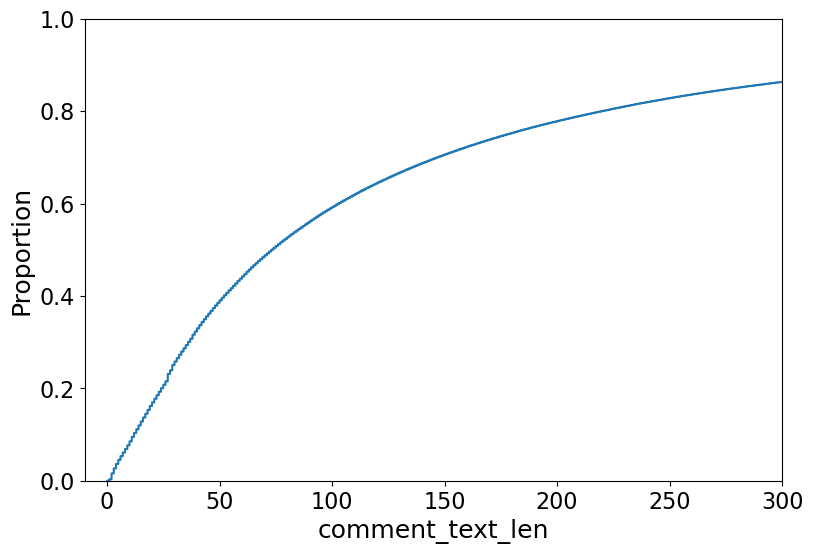

In [9]:
ax = sns.ecdfplot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
)
ax.set_xlim(-10, 300)

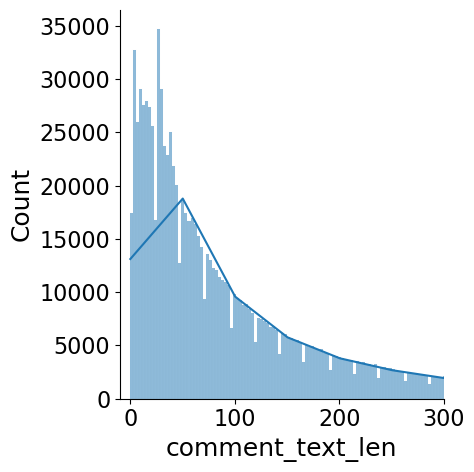

In [10]:
g = sns.displot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
    kde=True,
)
g.set(xlim=(-10, 300))

## How many words do we usually see in comments with text-len 10 or 11?

In [11]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 10]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"9,575.00","9,575"
mean,10.00,2
std,0.00,1
min,10.00,0
25%,10.00,1
50%,10.00,2
75%,10.00,2
max,10.00,5


In [12]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 11]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"10,701.00","10,701"
mean,11.00,2
std,0.00,1
min,11.00,0
25%,11.00,2
50%,11.00,2
75%,11.00,2
max,11.00,6


# Kick off sample job to load vectors & metadata [deprecated]

2021-08-04: We no longer need to load the dfs and keep them in memory to do quick tests. Instead use the two new parameters to limit how many files to read:
- `n_sample_posts_files`
- `n_sample_comments_files`

---
Legacy:
Loading the vectors/embeddings & metadat can take 5+ minutes each run.
So we're loading the data only once so that it's faster to test/iterate on different parameters.

It might've been slower before because I was reading from one large file. Let's see if it's better now that it's reading from multiple files at the same time (they should be read in parallel).
```
16:14:35 | INFO | "-- Start _load_raw_embeddings() method --"
16:14:35 | INFO | "Loading subreddit description embeddings..."
16:14:36 | INFO | "  (629, 512) <- Raw vectorized subreddit description shape"
16:14:36 | INFO | "Loading POSTS embeddings..."
16:15:12 | INFO | "  (262226, 512) <- Raw POSTS shape"
16:15:12 | INFO | "Loading COMMENTS embeddings..."
16:17:03 | INFO | "  (1108757, 512) <- Raw COMMENTS shape"
16:17:03 | INFO | "  Keep only comments for posts with embeddings"
16:17:04 | INFO | "  (1108757, 512) <- COMMENTS shape, after keeping only existing posts"
16:17:06 | INFO | "  0:02:30.685528 <- Total raw embeddings load time elapsed"
```

In [ ]:
%%time

mlflow.end_run("FAILED")

job_agg = AggregateEmbeddings(
    run_name=f"test_new_class-{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    **config_test_full_lc_false.config_flat
)

job_agg._load_raw_embeddings()
job_agg._load_metadata()

d_dfs = dict()
(
    d_dfs['df_v_sub'], d_dfs['df_v_posts'], d_dfs['df_v_comments'],
    d_dfs['df_subs_meta'], d_dfs['df_posts_meta'], d_dfs['df_comments_meta'],
    
) = (
    job_agg.df_v_sub, job_agg.df_v_posts, job_agg.df_v_comments,
    job_agg.df_subs_meta, job_agg.df_posts_meta, job_agg.df_comments_meta,
)

## Check shape & memory usage for main dfs

Some of these methods don't work for dask dfs... sigh.

In [ ]:
for k, df_ in d_dfs.items():
    print(f"\n{k}")
    try:
        print(f"{df_.shape} <- df shape")
        if 'meta' in k:
            # meta is expected to be usually pandas df
            df_.info()
            # df_.info(memory_usage='deep')
#             print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            
        else:
            df_.info()
            # df_.info(memory_usage='deep')
#             print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            # display(df_.iloc[:5, :15])
    except (AttributeError, TypeError):
        pass

# Test: download & loading files with new function
The first time we call the function, it'll download the files, and after that it should read the local (cached) file.

## Sub descriptions

In [34]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['subreddit_desc_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['subreddit_desc_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)


08:49:14 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_subreddits_description"


  0%|          | 0/4 [00:00<?, ?it/s]

08:49:14 | INFO | "  _common_metadata <- File already exists, not downloading"
08:49:14 | INFO | "  _metadata <- File already exists, not downloading"
08:49:14 | INFO | "  manual_meta-3767_by_514.txt <- File already exists, not downloading"
08:49:14 | INFO | "  part.0.parquet <- File already exists, not downloading"


CPU times: user 596 ms, sys: 5.88 ms, total: 602 ms
Wall time: 733 ms


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddings_271,e

## Post Embeddings
Without caching, it takes around 30-seconds to load the df.

In [16]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:22:38 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 638 ms, sys: 52 ms, total: 690 ms
Wall time: 1.05 s


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddin

In [17]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['posts_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['posts_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:23:59 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/9/614a38e6690c4f3ba08725b1585b2ee9/artifacts/df_vect_posts"


  0%|          | 0/51 [00:00<?, ?it/s]

CPU times: user 625 ms, sys: 16.7 ms, total: 642 ms
Wall time: 779 ms


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_270,embeddin

## Comment embeddings
From almost 6 minutes to less than one second!

```
# 1st run (download)
38/38 [05:51<00:00, 6.34s/it] 100%
CPU times: user 4min 12s, sys: 1min 21s, total: 5min 34s
Wall time: 5min 52s


# subsequent run (after chaching)
38/38 [00:00<00:00, 1550.48it/s] 100%
CPU times: user 634 ms, sys: 4.37 ms, total: 638 ms
Wall time: 786 ms

```



In [18]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['comments_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['comments_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:24:08 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 4min 12s, sys: 1min 21s, total: 5min 34s
Wall time: 5min 52s


,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_2

In [19]:
%%time

mlf.read_run_artifact(
    run_id=config_test_sample_lc_false.config_flat['comments_uuid'],
    artifact_folder=config_test_sample_lc_false.config_flat['comments_folder_embeddings'],
    read_function='dask_parquet',
    cache_locally=True,
)

09:30:01 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/10/e66c5db26bd64f6da09c012eea700d0a/artifacts/df_vect_comments"


  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 634 ms, sys: 4.37 ms, total: 638 ms
Wall time: 786 ms


,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,embeddings_30,embeddings_31,embeddings_32,embeddings_33,embeddings_34,embeddings_35,embeddings_36,embeddings_37,embeddings_38,embeddings_39,embeddings_40,embeddings_41,embeddings_42,embeddings_43,embeddings_44,embeddings_45,embeddings_46,embeddings_47,embeddings_48,embeddings_49,embeddings_50,embeddings_51,embeddings_52,embeddings_53,embeddings_54,embeddings_55,embeddings_56,embeddings_57,embeddings_58,embeddings_59,embeddings_60,embeddings_61,embeddings_62,embeddings_63,embeddings_64,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,embeddings_75,embeddings_76,embeddings_77,embeddings_78,embeddings_79,embeddings_80,embeddings_81,embeddings_82,embeddings_83,embeddings_84,embeddings_85,embeddings_86,embeddings_87,embeddings_88,embeddings_89,embeddings_90,embeddings_91,embeddings_92,embeddings_93,embeddings_94,embeddings_95,embeddings_96,embeddings_97,embeddings_98,embeddings_99,embeddings_100,embeddings_101,embeddings_102,embeddings_103,embeddings_104,embeddings_105,embeddings_106,embeddings_107,embeddings_108,embeddings_109,embeddings_110,embeddings_111,embeddings_112,embeddings_113,embeddings_114,embeddings_115,embeddings_116,embeddings_117,embeddings_118,embeddings_119,embeddings_120,embeddings_121,embeddings_122,embeddings_123,embeddings_124,embeddings_125,embeddings_126,embeddings_127,embeddings_128,embeddings_129,embeddings_130,embeddings_131,embeddings_132,embeddings_133,embeddings_134,embeddings_135,embeddings_136,embeddings_137,embeddings_138,embeddings_139,embeddings_140,embeddings_141,embeddings_142,embeddings_143,embeddings_144,embeddings_145,embeddings_146,embeddings_147,embeddings_148,embeddings_149,embeddings_150,embeddings_151,embeddings_152,embeddings_153,embeddings_154,embeddings_155,embeddings_156,embeddings_157,embeddings_158,embeddings_159,embeddings_160,embeddings_161,embeddings_162,embeddings_163,embeddings_164,embeddings_165,embeddings_166,embeddings_167,embeddings_168,embeddings_169,embeddings_170,embeddings_171,embeddings_172,embeddings_173,embeddings_174,embeddings_175,embeddings_176,embeddings_177,embeddings_178,embeddings_179,embeddings_180,embeddings_181,embeddings_182,embeddings_183,embeddings_184,embeddings_185,embeddings_186,embeddings_187,embeddings_188,embeddings_189,embeddings_190,embeddings_191,embeddings_192,embeddings_193,embeddings_194,embeddings_195,embeddings_196,embeddings_197,embeddings_198,embeddings_199,embeddings_200,embeddings_201,embeddings_202,embeddings_203,embeddings_204,embeddings_205,embeddings_206,embeddings_207,embeddings_208,embeddings_209,embeddings_210,embeddings_211,embeddings_212,embeddings_213,embeddings_214,embeddings_215,embeddings_216,embeddings_217,embeddings_218,embeddings_219,embeddings_220,embeddings_221,embeddings_222,embeddings_223,embeddings_224,embeddings_225,embeddings_226,embeddings_227,embeddings_228,embeddings_229,embeddings_230,embeddings_231,embeddings_232,embeddings_233,embeddings_234,embeddings_235,embeddings_236,embeddings_237,embeddings_238,embeddings_239,embeddings_240,embeddings_241,embeddings_242,embeddings_243,embeddings_244,embeddings_245,embeddings_246,embeddings_247,embeddings_248,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,embeddings_257,embeddings_258,embeddings_259,embeddings_260,embeddings_261,embeddings_262,embeddings_263,embeddings_264,embeddings_265,embeddings_266,embeddings_267,embeddings_268,embeddings_269,embeddings_2